# Imports

## Basic Stuff

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import shap
import pickle
import os
import math

## sklearn

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance
from scipy.stats import skew, kurtosis

## Models

In [3]:
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.svm import SVC

# Load CSVs

In [4]:
control_df = pd.read_csv("../Dataset/train_radiomics_occipital_CONTROL.csv")
train_df = pd.read_csv("../Dataset/train_radiomics_hipocamp.csv")
test_df = pd.read_csv("../Dataset/test_radiomics_hipocamp.csv")
dummy_df = pd.read_csv("../Dataset/dummy_submission.csv")

# Data Exploration

## Category Encoder and Decoder

In [5]:
def target_encoder(df, target="Transition"):
    le_make = LabelEncoder()
    df[f"{target}_code"] = le_make.fit_transform(df[target])
    return le_make

def target_decoder(le_make, preds):
    return le_make.inverse_transform(preds)


In [6]:
le_make_train = target_encoder(train_df)
le_make_control = target_encoder(control_df)

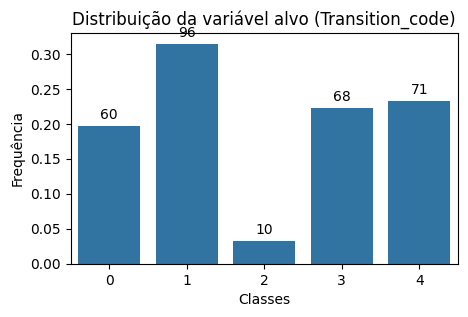

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenção da distribuição e contagem de cada classe
target_distribution = train_df['Transition_code'].value_counts(normalize=True).sort_index()
target_counts = train_df['Transition_code'].value_counts().sort_index()

# Criação do gráfico
plt.figure(figsize=(5, 3))
ax = sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title("Distribuição da variável alvo (Transition_code)")
plt.xlabel("Classes")
plt.ylabel("Frequência")

# Adiciona contador em cima de cada barra com a ordem correta
for index, value in enumerate(target_distribution.index):
    ax.text(index, target_distribution[value] + 0.01, f'{target_counts[value]}', ha='center')

plt.show()


## MatPlots

In [8]:
def show_histogram(df,title="histogram"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    plt.title(title)
    sns.histplot(df)
    plt.show()

In [9]:
def show_pie(df,title="pie"):
    labels = df.unique().tolist()
    counts = df.value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%",shadow=True)
    ax1.axis("equal")
    plt.title(title)
    plt.show()

In [10]:
def show_boxplot(df,title="boxplot"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    df.boxplot()
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()


In [11]:
def show_heatmap(df,title="correlation heatmap"):
    df = df.select_dtypes(include="number")
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.25,left=0.22,right=0.95)
    plt.xticks(rotation=15)
    plt.title(title)
    sns.heatmap(df.corr(),annot=True,cmap="coolwarm",linewidths=0.5)
    plt.show()

In [12]:
def show_jointplot(df,x_label,y_label,title="jointplot",hue="Transition_code"):
    sns.jointplot(data=df,x=x_label,y=y_label,hue=hue)
    plt.show()

In [13]:
def show_catplot(df, x_label, y_label, title="catplot", hue="Transition_code"):
    sns.catplot(data=df, x=x_label, y=y_label, hue=hue)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [14]:
def show_pairplot(df,hue="Transition_code"):
    sns.pairplot(df,hue=hue)
    plt.show()

## Basic Exploration

In [15]:
def main_exploration(df):
    print(df.shape) 

In [16]:
def numerical_exploration(df):
    # age exploration
    show_histogram(df["Age"],title="Histogram")
    print(df["Age"].describe())

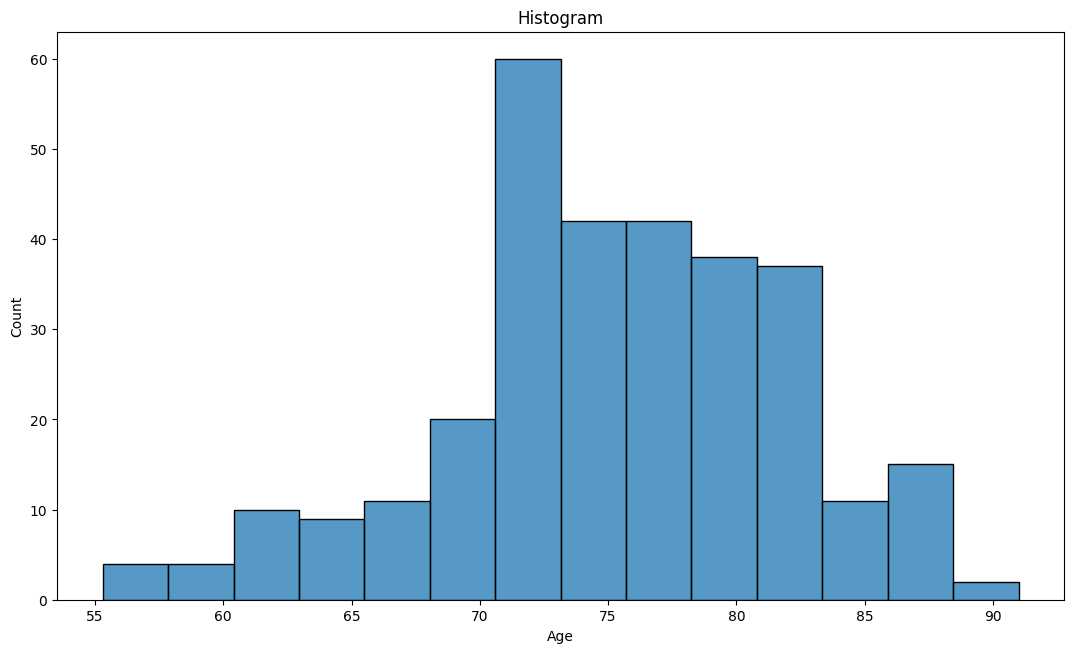

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


In [17]:
numerical_exploration(train_df)

In [18]:
def categorical_exploration(df):
    """
    Transition description:
    CN - Cognitive Normal, estado normal
    MCI - Mild Cognitive Impairment, estado entre o avanço normal da perda de memoria com a idade e um certo declinio serio de demencia
    AD - Azlheimer Disease, forma mais comum de demencia nas pessoas mais velhas
    """
    categorical_df = df[["Sex","Transition"]]

    for column in categorical_df.columns:
        show_histogram(categorical_df[column],title=f"{column} histogram")
        print(df[column].value_counts())

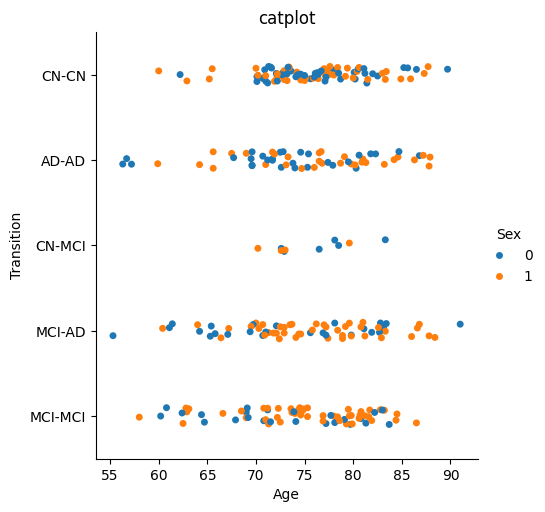

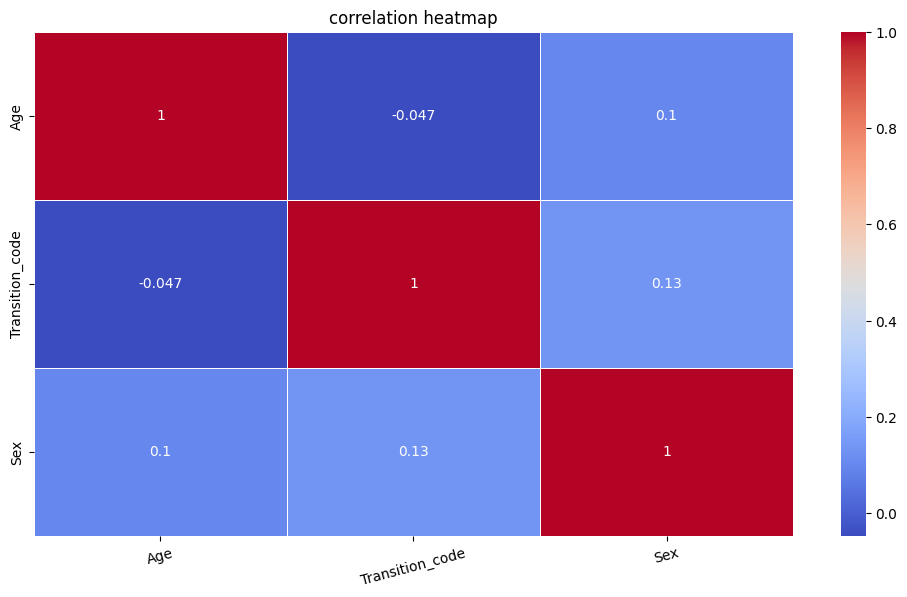

In [19]:
show_catplot(train_df, "Age", "Transition", hue="Sex")
show_heatmap(train_df[["Age","Transition_code","Sex"]])

<Axes: >

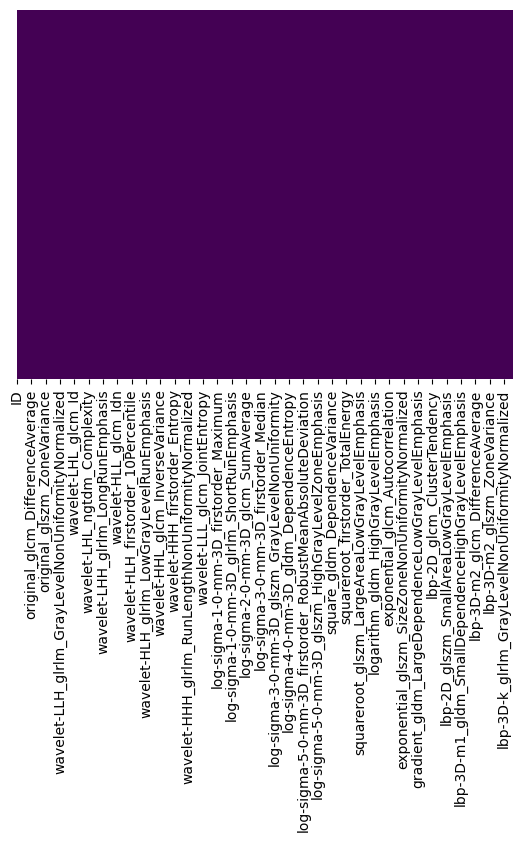

In [20]:
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [21]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]
def diagnostics_configs(df):
    for col in diagnostics_configs_columns:
        print(len(df[col].unique()))

In [22]:
diagnostics_configs(train_df)

1
1


In [23]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 
def diagnostics_versions_explorer(df):
    for column in diagnostics_versions_columns:
        print(column,": ")
        values = df[column].unique()
        print(values)

In [24]:
diagnostics_versions_explorer(train_df)

diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']


In [25]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 

In [26]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]

In [27]:
unnecessary_columns = diagnostics_versions_columns + diagnostics_configs_columns +["diagnostics_Image-original_Dimensionality","diagnostics_Image-original_Minimum","diagnostics_Image-original_Size","diagnostics_Mask-original_Spacing","diagnostics_Image-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Image-original_Hash","diagnostics_Mask-original_Hash","ID","Image","Mask",'diagnostics_Mask-original_CenterOfMassIndex']

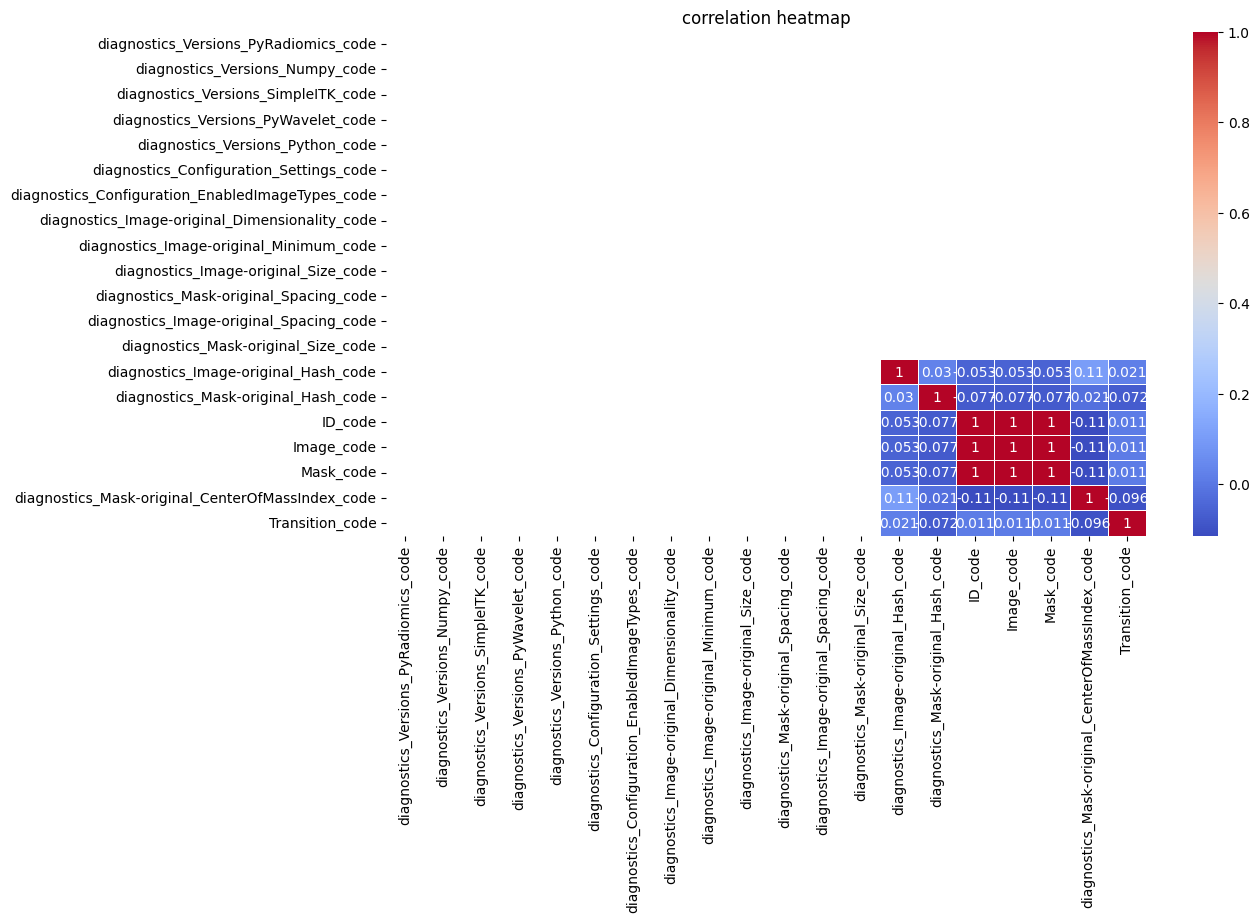

In [28]:
unnecessary_df = pd.DataFrame()
for col in unnecessary_columns+["Transition"]:
    le_make = LabelEncoder()
    unnecessary_df[f"{col}_code"] = le_make.fit_transform(train_df[col])

show_heatmap(unnecessary_df)

## Correlations

In [29]:
def top_correlations(df, target="Transition_code",starts_with=None,number=10,ascending=False):
    if starts_with == None:
        corr_columns = df.select_dtypes(include=["int64","float64"]).columns
    else:
        corr_columns = df.columns[df.columns.str.startswith(starts_with)]

    corr_matrix = df[corr_columns].corrwith(df[target])

    top_features = corr_matrix.sort_values(ascending=ascending).head(number).index.tolist()
    top_features.append(target)
    top_features = pd.Index(top_features)
    
    return top_features

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


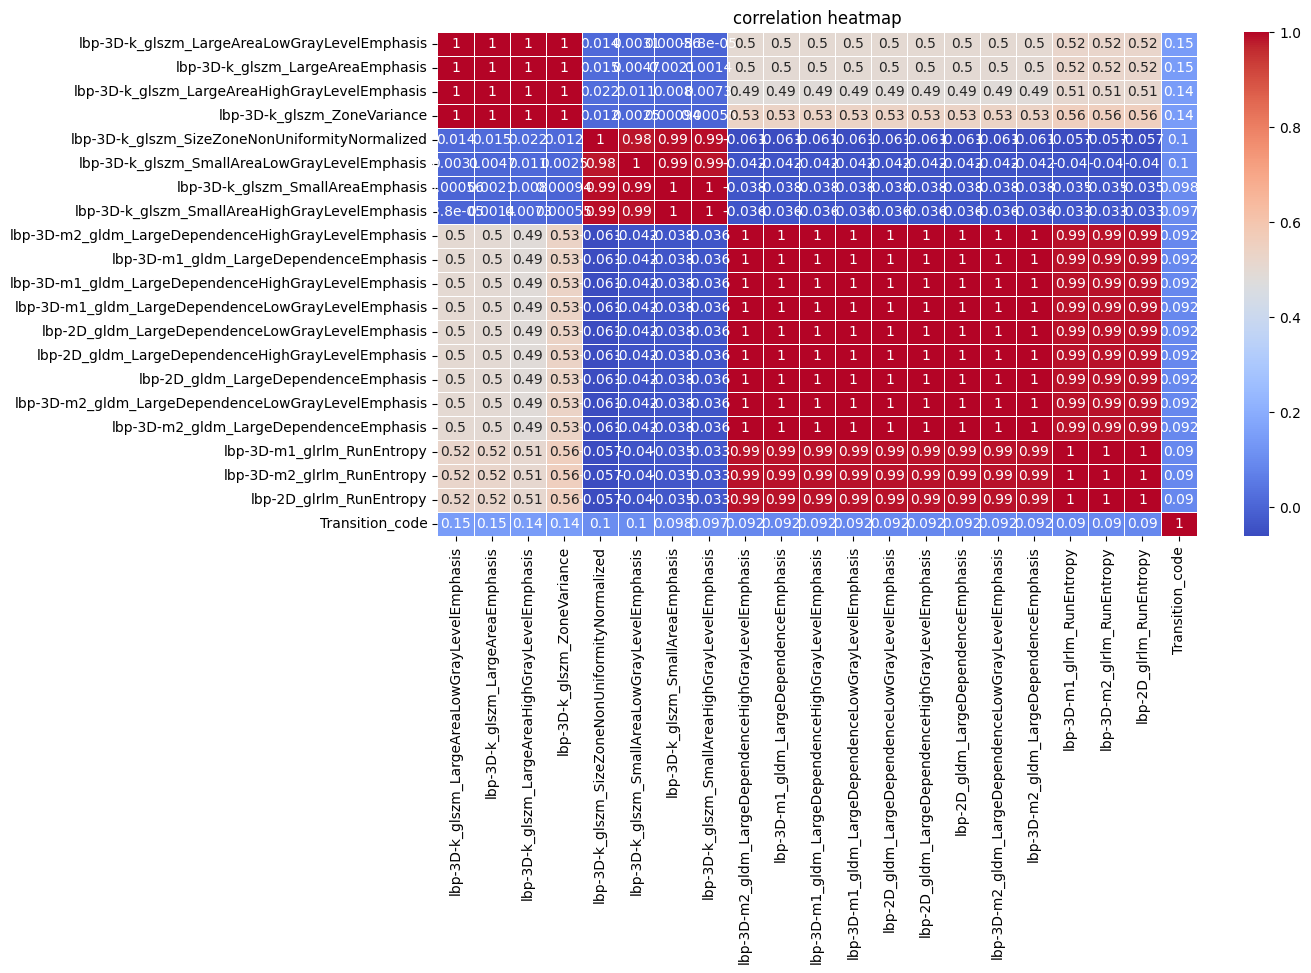

In [30]:
rad_corr = top_correlations(train_df,starts_with="lbp",number=20)
show_heatmap(train_df[rad_corr])

# Save & Load Data

In [31]:
uni_path = "../DataSaver/"

def save_stuff(data,path):
    file_path = os.path.join(uni_path, path)
    
    with open(file_path,"wb") as file:
        pickle.dump(data,file)

def load_stuff(path):
    file_path = os.path.join(uni_path,path)

    with open(file_path,"rb") as file:
        data = pickle.load(file)

    return data

# Data Processing

## Drop Unnecessary Columns

In [32]:
control_df = control_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
train_df = train_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
test_df = test_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")

## Nunique Columns

In [33]:
nunique_columns = train_df.columns[train_df.nunique() == 1].tolist()
train_df = train_df.drop(columns=nunique_columns, errors="ignore")
test_df = test_df.drop(columns=nunique_columns, errors="ignore")
control_df = control_df.drop(columns=nunique_columns, errors="ignore")

## Non Numerical Columns

In [34]:
# Separar a coluna de BoundingBox em várias colunas
train_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = train_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
train_df[['x_center', 'y_center', 'z_center']] = train_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [35]:
# Separar a coluna de BoundingBox em várias colunas
test_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = test_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
test_df[['x_center', 'y_center', 'z_center']] = test_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [36]:
# Separar a coluna de BoundingBox em várias colunas
control_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = control_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
control_df[['x_center', 'y_center', 'z_center']] = control_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [37]:
train_df = train_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
test_df = test_df.drop(['diagnostaics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
control_df = control_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")

In [38]:
main_exploration(train_df)

(305, 2024)


In [39]:
train_df = train_df.select_dtypes(include=['number'])
control_df = control_df.select_dtypes(include=['number'])
test_df = test_df.select_dtypes(include=['number'])

## Data Scaler

In [40]:
from sklearn.preprocessing import StandardScaler

def data_scaler(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(scaler_df),columns=scaler_df.columns)
    return df_scaled


In [41]:
scaled_train_df = data_scaler(train_df)
scaled_control_df = data_scaler(control_df)
scaled_test_df = data_scaler(test_df)

scaled_train_df["Transition_code"] = train_df["Transition_code"].values
scaled_control_df["Transition_code"] = train_df["Transition_code"].values

## Correlation Analisys

In [42]:
corr_df = scaled_train_df.copy()
corr_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
target = "Transition_code"

In [43]:
corr_threshold = 0
def apply_correlation(df,threshold):
    df = df.drop(columns=["Transition"],errors="ignore")
    correlation = df.corr()[target].abs().sort_values(ascending=False)
    important_features = correlation[correlation > threshold].index.tolist()
    
    if target in important_features:
        important_features.remove(target)

    return important_features

In [44]:
important_features = apply_correlation(scaled_train_df, corr_threshold)

In [45]:
corr_train_df = scaled_train_df[important_features]
corr_control_df = scaled_control_df[important_features]
corr_test_df = scaled_test_df[important_features]

In [46]:
corr_train_df["Transition_code"] = train_df["Transition_code"].values
corr_control_df["Transition_code"] = train_df["Transition_code"].values

In [47]:
main_exploration(corr_train_df)
main_exploration(corr_control_df)
main_exploration(corr_test_df)

(305, 2023)
(305, 2023)
(100, 2022)


# Testing Phase

In [48]:
def define_X_y(train_df, test_df = pd.DataFrame(),random_state=27):
    if test_df.empty:
        X = train_df.drop(columns=["Transition_code","Transition"],errors="ignore")
        y = train_df["Transition_code"]

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=random_state)

        return x_train, x_test, y_train, y_test

    else:
        x_train = train_df.drop("Transition_code",axis=1,errors="ignore")
        y_train = train_df["Transition_code"]
        x_test = test_df

        return x_train, x_test, y_train, None

In [49]:
results = {}
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)
main_exploration(x_train)
main_exploration(x_test)

scorer = make_scorer(f1_score, average='macro')

(244, 2022)
(61, 2022)


## Params

### Grid Params

In [50]:
param_grid_rf = {
    'n_estimators': [80, 150, 250, 400],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 4, 8, 10],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

param_grid_xgb = {
    'learning_rate': [0.1, 0.15, 0.2,0.25],
    'n_estimators': [80, 150, 250, 400],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [ 0.5, 0.7, 0.8],
    'min_child_weight': [1, 3, 5, 8]
}

param_grid_light = {
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.3],
    'num_leaves': [20, 40, 60, 80, 100],
    'max_depth': [5, 10, 15, 20],
    'min_data_in_leaf': [5, 10, 20, 30, 60],
    'bagging_fraction': [0.5, 0.7, 0.9, 1.0],
    'class_weight': ['balanced', None]
}

param_grid_svm = {
    'C': [0.1, 1, 10, 50, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced', None],
    'degree': [2, 3, 4, 5],
    'tol': [1e-5, 1e-4, 1e-3],
    'cache_size': [100, 200, 300, 500]
}

param_grid_gb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [20, 50, 100, 150, 250, 400],
    'max_depth': [5, 10, 15, 20],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 3, 4, 6]
}

param_grid_cat = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'iterations': [20, 100, 200, 400],
    'depth': [4, 6, 8, 10, 12, 15],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'border_count': [32, 50, 100, 150, 255],
    'class_weights': [None, 'balanced']  # Para lidar com desbalanceamento
}


### Bayes Params

In [51]:
param_baye_rf = {
    'n_estimators': (80, 400),
    'max_depth': (5, 35),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 8),
    'bootstrap': (0, 1),
    'class_weight': (0, 1),
}

param_baye_xgb = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (80, 400),
    'max_depth': (5, 30),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.3, 0.8),
    'min_child_weight': (1, 8),
}

param_baye_gb = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (20, 400),
    'max_depth': (5, 20),
    'subsample': (0.4, 1.0),
    'min_samples_split': (2, 8),
    'min_samples_leaf': (1, 6),
}

param_baye_cat = {
    'learning_rate': (0.01, 0.3),       
    'iterations': (20, 400),         
    'depth': (4, 15),                  
    'l2_leaf_reg': (1, 10),              
    'border_count': (32, 255)
}

param_baye_light = {
    'learning_rate': (0.05, 0.3),     
    'num_leaves': (20, 100), 
    'max_depth': (5, 20),   
    'min_data_in_leaf': (5, 60),  
    'bagging_fraction': (0.3, 1.0)      
}

param_baye_svm = {
    'C': (0.1, 100),  # Intervalo para o parâmetro C
    'gamma': (0.001, 1),  # Intervalo para gamma
    'kernel': (0, 1),  # 0 para linear, 1 para rbf
    'class_weight': (0, 1),  # 0 para None, 1 para 'balanced'
    'degree': (2, 5),  # Intervalo para o grau do polinômio (para kernel polinomial)
    'tol': (1e-5, 1e-1),  # Intervalo para a tolerância
    'cache_size': (100, 500),  # Intervalo para o tamanho do cache
}

## Models

### SVM

In [52]:
def svm_train_model(x_train,y_train):
    model = SVC(random_state=27)
    model.fit(x_train,y_train)

    return model

# Grid Model
def svm_grid_train_model(x_train,y_train, param_grid=param_grid_svm):
    model = SVC(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid, cv=cv, n_iter=200,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

def objective_svm(C, gamma, kernel, class_weight, degree, tol, cache_size):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)
    
    params = {
        'C': C,
        'gamma': 'scale' if round(gamma) == 0 else gamma,  # 'scale' ou um valor float de gamma
        'kernel': 'linear' if round(kernel) == 0 else 'rbf',  # 'linear' ou 'rbf'
        'class_weight': None if round(class_weight) == 0 else 'balanced',
        'degree': int(degree) if round(kernel) == 1 else 3,  # Degree apenas para kernel polinomial
        'tol': tol,
        'cache_size': cache_size,  # Cache size em MB
        'random_state': 27
    }
    
    model = SVC(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy').mean()  # Troque "scorer" por "accuracy"
    return score

def svm_baye_train_model(x_train, y_train, param_baye=param_baye_svm):
    svm_bo = BayesianOptimization(
        f=objective_svm,
        pbounds=param_baye,
        random_state=27,
    )
    
    svm_bo.maximize(init_points=7, n_iter=45)

    best_params = svm_bo.max['params']

    gamma = 'scale' if round(best_params["gamma"]) == 0 else best_params["gamma"]
    kernel = 'linear' if round(best_params["kernel"]) == 0 else 'rbf'
    best_params_updated = {
        'C': best_params['C'],
        'gamma': gamma,
        'kernel': kernel,
        'class_weight': None if round(best_params['class_weight']) == 0 else 'balanced',
        'degree': int(best_params['degree']) if kernel == 'rbf' else 3,  # Degree só para kernel 'rbf'
        'tol': best_params['tol'],
        'cache_size': best_params['cache_size'],
        'random_state': 27
    }

    print(best_params_updated)

    model = SVC(**best_params_updated)
    model.fit(x_train, y_train)

    svm_results = pd.DataFrame(svm_bo.res)
    svm_results.sort_values(by="target", ascending=False, inplace=True)

    return model, svm_results, svm_bo.max

### RandomForest

In [53]:
# Basic Model
def random_forest_model(x_train,y_train):
    model = RandomForestClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def random_forest_grid_model(x_train,y_train, param_grid_rf=param_grid_rf):
    model = RandomForestClassifier(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=27)
    
    grid_search = RandomizedSearchCV(model, param_grid_rf, cv=cv, n_iter=200,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

#Bayes Model
def objective_random_forest(n_estimators, max_depth, min_samples_split, min_samples_leaf,bootstrap,class_weight):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)
    
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'bootstrap': bool(round(bootstrap)),
        'class_weight': None if round(class_weight) == 0 else 'balanced',
        'random_state': 27
    }
    
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score

def random_forest_baye_model(x_train,y_train, param_baye=param_baye_rf):
    rf_bo = BayesianOptimization(
        f=objective_random_forest,
        pbounds=param_baye,
        random_state=27,
    )
    
    rf_bo.maximize(init_points=7, n_iter=45)

    best_params = rf_bo.max['params']
    bootstrap = bool(round(best_params["bootstrap"]))
    best_params_updated = {
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),
        'min_samples_split': int(best_params['min_samples_split']),
        'min_samples_leaf': int(best_params['min_samples_leaf']),
        'bootstrap': bootstrap,
        'class_weight': None if round(best_params['class_weight']) == 0 else 'balanced',
        'random_state': 27
    }

    print(best_params_updated)

    model = RandomForestClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    rf_results = pd.DataFrame(rf_bo.res)
    rf_results.sort_values(by="target",ascending=False,inplace=True)

    return model, rf_results, rf_bo.max

### XGBoost

In [54]:
# Basic Model
def xgboost_model(x_train,y_train):
    model = XGBClassifier(random_state=27)
    model.fit(x_train,y_train)

    return model

# Grid Model
def xgboost_grid_model(x_train,y_train, param_grid_xgb=param_grid_xgb):
    model = XGBClassifier(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid_xgb, cv=cv, n_iter=200,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)
    

    return grid_search.best_estimator_

# Baye Model
def objective_xgboost(learning_rate, n_estimators, max_depth, subsample, colsample_bytree,min_child_weight):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight,
        'random_state': 27
    }
    
    model = XGBClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score
    
def xgboost_baye_model(x_train,y_train, param_baye=param_baye_xgb):
    xgb_bo = BayesianOptimization(
    f=objective_xgboost,
    pbounds=param_baye,
    random_state=27,
    )
    
    xgb_bo.maximize(init_points=7, n_iter=30)

    best_params = xgb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']), 
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'min_child_weight': best_params['min_child_weight'],
        'random_state': 27
    }

    print(best_params_updated)
    
    model = XGBClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    xgb_results = pd.DataFrame(xgb_bo.res)
    xgb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, xgb_results, xgb_bo.max

### GradientBoost

In [55]:
# Basic Model
def gradient_boost_model(x_train, y_train):
    model = GradientBoostingClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def gradient_grid_model(x_train,y_train, param_grid_gb=param_grid_gb):
    model = GradientBoostingClassifier(random_state=27)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=27)

    grid_search_gb = GridSearchCV(model, param_grid_gb, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search_gb.fit(x_train,y_train)
    print(grid_search_gb.best_params_)

    return grid_search_gb.best_estimator_


# Baye Model
def objective_gradient_boost(learning_rate, n_estimators, max_depth, subsample,min_samples_split,min_samples_leaf):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'random_state': 27
    }
    
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def gradient_baye_model(x_train,y_train, param_baye=param_baye_gb):
    gb_bo = BayesianOptimization(
        f=objective_gradient_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    gb_bo.maximize(init_points=7, n_iter=70)

    best_params = gb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),  
        'subsample': best_params['subsample'],
        'min_samples_split': int(best_params['min_samples_split']), 
        'min_samples_leaf': int(best_params['min_samples_leaf']), 
        'random_state': 27 
    }

    print(best_params_updated)
    
    model = GradientBoostingClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    gb_results = pd.DataFrame(gb_bo.res)
    gb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, gb_results, gb_bo.max

### LightGBM

In [56]:
# Basic Model
def light_boost_model(x_train,y_train):
    model =  lgb.LGBMClassifier(verbose=-1)
    model.fit(x_train,y_train)

    return model

# Grid Model
def light_grid_train_model(x_train,y_train, param_grid=param_grid_light):
    model = lgb.LGBMClassifier(verbose=-1,random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid_light, cv=cv, n_iter=200,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

# Bayes Model
def objective_light_boost(learning_rate, num_leaves, max_depth, min_data_in_leaf, bagging_fraction):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        'bagging_fraction': bagging_fraction,
        'boosting_type': 'gbdt',
        'objective': 'multiclass', 
        'num_class': 5,
        'is_unbalance': True,
        'n_jobs': -1,
        'random_state': 27,
        'verbose': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def light_baye_train_model(x_train, y_train, param_baye=param_baye_light):
    light_bo = BayesianOptimization(
        f=objective_light_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    light_bo.maximize(init_points=7, n_iter=45)

    best_params = light_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'num_leaves': int(best_params['num_leaves']),
        'max_depth': int(best_params['max_depth']),
        'min_data_in_leaf': int(best_params['min_data_in_leaf']),
        'bagging_fraction': best_params['bagging_fraction'],
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'is_unbalance': True,
        'n_jobs': -1,
        'random_state': 27,
        'verbose': -1
    }

    print(best_params_updated)
    
    model = lgb.LGBMClassifier(**best_params_updated)
    model.fit(x_train, y_train)

    light_results = pd.DataFrame(light_bo.res)
    light_results.sort_values(by="target", ascending=False, inplace=True)

    return model, light_results, light_bo.max

### CatBoosting

In [57]:
# Basic Model
def cat_boost_model(x_train,y_train):
    model = CatBoostClassifier(verbose=False, task_type="GPU")
    model.fit(x_train,y_train)

    return model

# Bayes Model
def objective_cat_boost(learning_rate, iterations, depth, l2_leaf_reg, border_count):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'iterations': int(iterations),
        'depth': int(depth),
        'l2_leaf_reg': l2_leaf_reg,
        'border_count': int(border_count),
        'task_type': 'GPU',
        'random_seed': 27,
        'verbose': 0
    }
    
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def cat_baye_model(x_train, y_train, param_baye=param_baye_cat):
    cat_bo = BayesianOptimization(
        f=objective_cat_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    cat_bo.maximize(init_points=5, n_iter=20)


    best_params = cat_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'iterations': int(best_params['iterations']),
        'depth': int(best_params['depth']),
        'l2_leaf_reg': best_params['l2_leaf_reg'],
        'border_count': int(best_params['border_count']),
        'task_type': 'GPU',
        'random_seed': 27,
        'verbose': 0
    }

    print(best_params_updated)
    

    model = CatBoostClassifier(**best_params_updated)
    model.fit(x_train, y_train)


    cat_results = pd.DataFrame(cat_bo.res)
    cat_results.sort_values(by="target", ascending=False, inplace=True)

    return model, cat_results, cat_bo.max

### Logistic Regression L2

In [58]:
def log_reg_model(x_train,y_train):
    model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear',random_state=27)
    model.fit(x_train,y_train)
    
    return model

### Voting Ensemble

In [59]:
def voting_ensemble(x_train,y_train,estimators):
    model = VotingClassifier(estimators=estimators, voting="hard")
    model.fit(x_train,y_train)
    
    return model

### Stacking Ensemble

In [60]:
def stacking_ensemble(x_train,y_train,estimators):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
    
    model = StackingClassifier(
        estimators=estimators, 
        final_estimator=LogisticRegression(max_iter=3000, random_state=27), 
        cv=cv, 
        n_jobs=-1
    )
    
    model.fit(x_train,y_train)
    
    return model

## Models Applier

In [61]:
def apply_basic_models(x_train,y_train,x_test,y_test,n_repeats=5, title="Models Macro F1 Comparison", rf=1, xgb=1, gradient=0, cat=0, log=0, light=1,svm=1):
        
    if rf:
        rf_model = random_forest_model(x_train,y_train)
        results["RandomForest"] = [rf_model,None]
    else:
        rf_model = None

    if xgb:
        xgb_model = xgboost_model(x_train,y_train)
        results["XGBoost"] = [xgb_model,None]
    else:
        xgb_model = None
        
    if gradient:
        gradient_model = gradient_boost_model(x_train,y_train)
        results["GradientBoost"] = [gradient_model,None]
    else:
        gradient_model = None
        
    if cat:
        cat_model = cat_boost_model(x_train,y_train)
        results["CatBoost"] = [cat_model,None]
    else:
        cat_model = None
        
    if log:
        log_model = log_reg_model(x_train,y_train)
        results["Logistic"] = [log_model,None]
    else:
        log_model = None      

    if light:
        light_model = light_boost_model(x_train,y_train)
        results["LightGBM"] = [light_model,None]
    else:
        light_model = None  

    if svm:
        svm_model = svm_train_model(x_train,y_train)
        results["SVM"] = [svm_model,None]
    else:
        svm_model = None 

    if len(x_train) != 305:
        models_comparison(results,title,x_train=x_train,y_train=y_train,n_repeats=n_repeats)

    return rf_model, xgb_model, gradient_model, cat_model, log_model, light_model, svm_model

## Models Comparison

In [62]:
def models_comparison(results, title, x_train, y_train,n_repeats=5):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=27)
    
    for result in results:
        if results[result][1] is None:
            # Calcular F1 Score usando cross-validation
            f1_scores = cross_val_score(
                results[result][0], x_train, y_train, cv=cv, scoring=make_scorer(f1_score, average="macro")
            )
            results[result][1] = f1_scores.mean()
            print(f"F1 Macro Score em {result}: {results[result][1]} ± {round(f1_scores.std(),3)}")
        
        else:
            print(f"F1 Macro Score em {result}: {results[result][1]}")
        
    
    # Criar gráfico
    models_score = plt.figure(figsize=(6, 3))

    mod = list(results.keys())
    f1 = list([score[1] for score in results.values()])
    
    plt.bar(mod, f1, color="lightblue", width=0.5)
    plt.xlabel("Modelo")
    plt.ylabel("Macro F1")
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()

## MultiClass Analysis

In [63]:
def class_accuracy(model,x_test,y_test):
    conf_matrix = confusion_matrix(y_test, stacking_model.predict(x_test))
    # grafico de barras com a percentagem de acertos
    class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    class_accuracies_percentage = class_accuracies * 100  
    total_per_class = np.sum(conf_matrix, axis=1) 
    correct_per_class = np.diag(conf_matrix) 
    
    plt.figure(figsize=(7, 4))
    classes = np.unique(y_test)
    plt.bar(classes, class_accuracies_percentage, color='skyblue', alpha=0.8)
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy per Class")
    plt.ylim(0, 100) 
    

    for i, v in enumerate(class_accuracies_percentage):
        text = f"{correct_per_class[i]}/{total_per_class[i]} ({v:.1f}%)"
        plt.text(classes[i], v + 2, text, ha='center', fontsize=10)
    
    plt.show()
    
    # matriz de confusão
    
    plt.figure(figsize=(7, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predict")
    plt.ylabel("Real Values")
    plt.title("Confusion Matrix")
    plt.show()


## ROC & AUC Analysis

In [64]:
def roc_auc(models, X_train, y_train, X_test, y_test):
    # Binariza o target para multiclasse
    y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])
    n_classes = y_test_bin.shape[1]

    # Define o número de linhas e colunas para a grade de subgráficos, ajustando para o número de classes
    n_cols = 2  # Define um número fixo de colunas
    n_rows = math.ceil(n_classes / n_cols)  # Calcula o número de linhas necessárias

    # Configura os subgráficos e aumenta o tamanho da figura
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
    axs = axs.flatten()  # Achata a matriz de axs para facilitar o acesso
    
    colors = ['blue', 'green', 'red', 'purple', 'orange']  # Cores para cada modelo

    for classe in range(n_classes):
        ax = axs[classe]  # Acessa o subplot correspondente à classe

        for i, (name, model) in enumerate(models.items()):
            y_score = model.predict_proba(X_test)
            
            # Calcula a curva ROC e AUC para a classe atual e o modelo atual
            fpr, tpr, _ = roc_curve(y_test_bin[:, classe], y_score[:, classe])
            auc = roc_auc_score(y_test_bin[:, classe], y_score[:, classe])
            
            
            # Plota a curva ROC para o modelo na classe atual
            ax.plot(fpr, tpr, color=colors[i], linestyle='--', label=f'{name} {classe} (AUC = {auc:.2f})')
        
        # Linha de referência (modelo aleatório)
        ax.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')
        ax.set_title(f'Classe {classe}')
        ax.set_xlabel('Falsos Positivos (FPR)')
        
        # Apenas o primeiro gráfico precisa do rótulo do eixo Y
        if classe % n_cols == 0:
            ax.set_ylabel('Verdadeiros Positivos (TPR)')
        
        # Adiciona a legenda em cada subgráfico
        ax.legend(loc='lower right')

    # Remove subgráficos extras, caso o número de classes não preencha todos os subgráficos
    for i in range(n_classes, len(axs)):
        fig.delaxes(axs[i])
    
    # Título principal
    plt.suptitle('Curvas ROC Multiclasse Comparativas (One-vs-Rest)')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta o layout para incluir o título
    plt.show()

## Models Tester

F1 Macro Score em RandomForest: 0.2594590131728912 ± 0.033
F1 Macro Score em XGBoost: 0.28181355795906876 ± 0.068
F1 Macro Score em LightGBM: 0.3334775374426472 ± 0.058
F1 Macro Score em SVM: 0.27796276787573826 ± 0.057


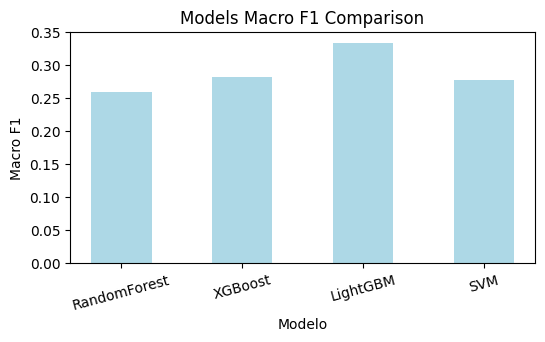

In [65]:
rf_model,xgb_model,gradient_model,cat_model, log_model,light_model, svm_model = apply_basic_models(x_train,y_train,x_test,y_test,n_repeats=1)

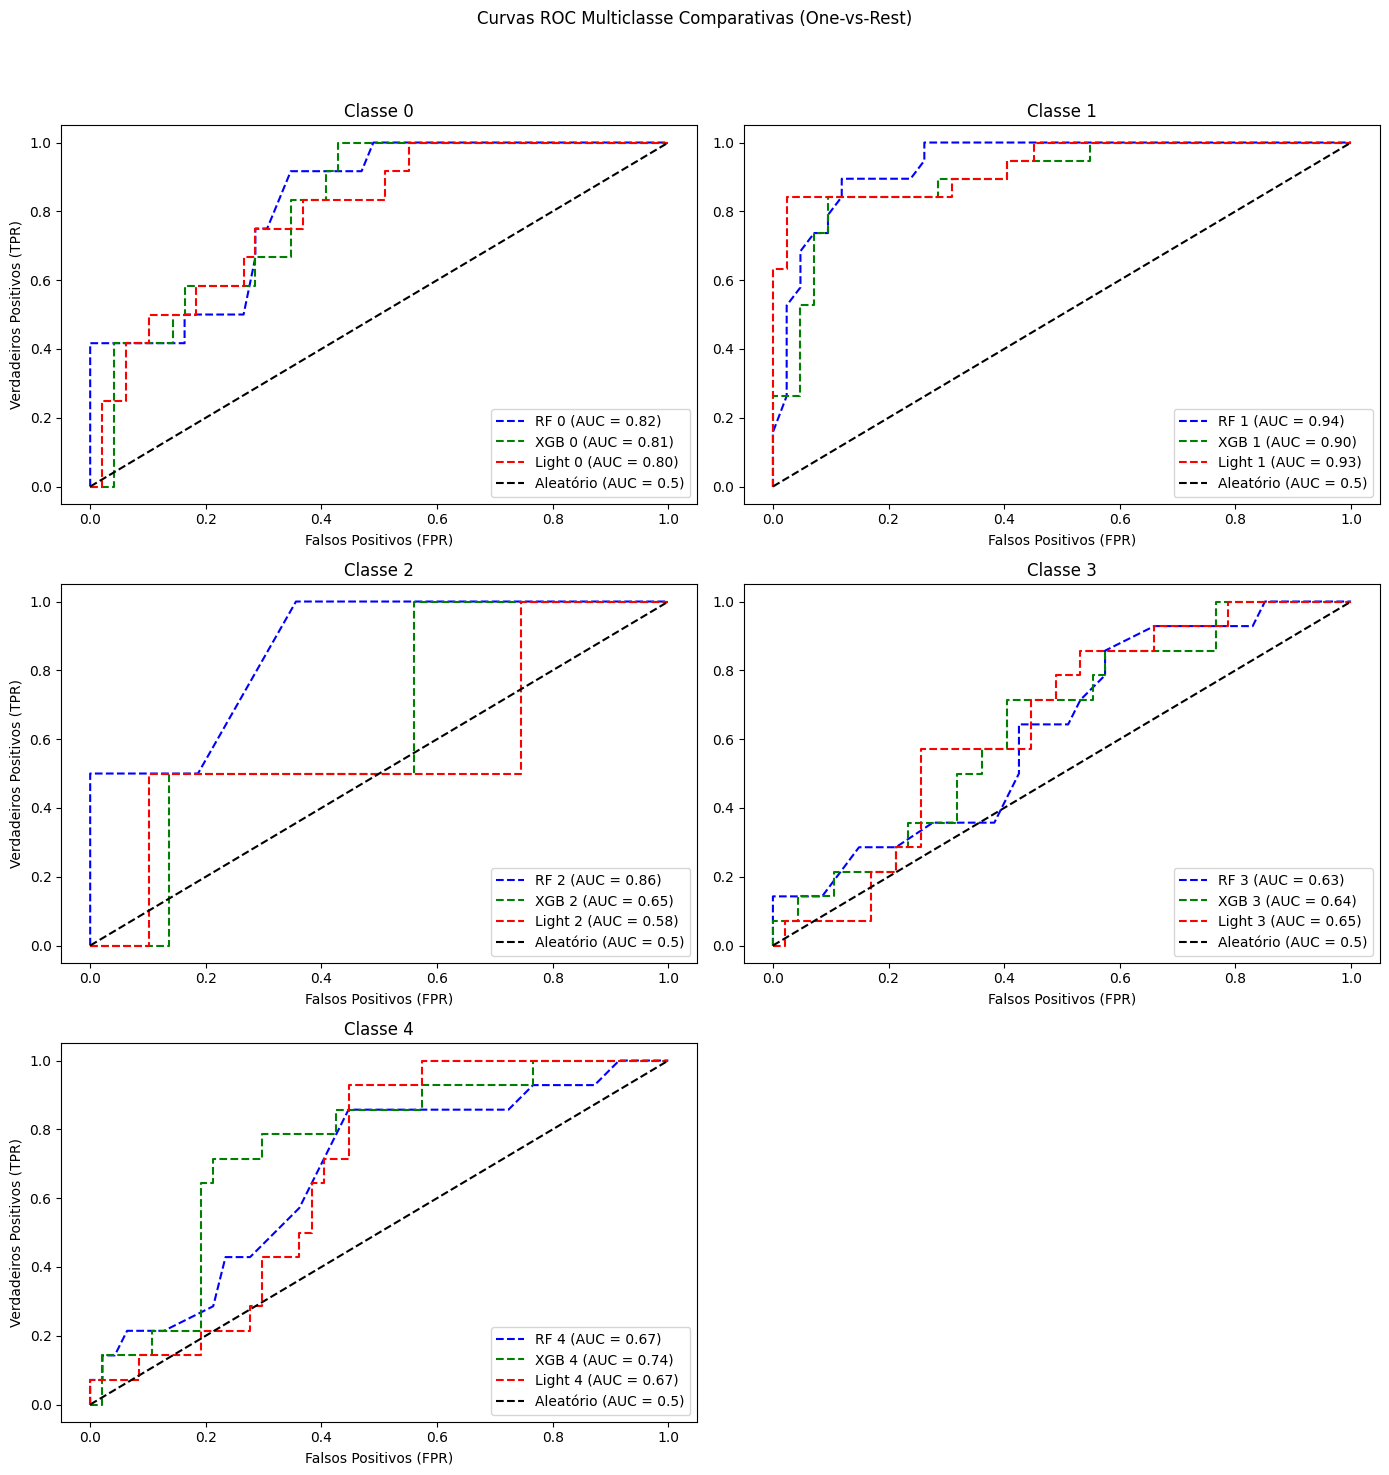

In [66]:
models = {"RF": rf_model,"XGB": xgb_model,"Light":light_model}
roc_auc(models,x_train,y_train,x_test,y_test)

## Permutation Importance

In [67]:
#pi_xgb_result = permutation_importance(xgb_model,x_test,y_test,n_repeats=10,random_state=27,n_jobs=-1

pi_xgb_result = load_stuff("Permutations/pi_xgb_result.pkl")

## SHAP Analysis

In [68]:
X_shap_init = corr_train_df.drop("Transition_code", axis=1)  # Features
y_shap_init = corr_train_df["Transition_code"]

In [69]:
#explainer = shap.TreeExplainer(xgb_model,X_shap_init)
#shap_values_xgb = explainer(X_shap_init)


shap_values_xgb = load_stuff("SHAP_Values/shap_values_xgb.pkl")

## Deep SHAP Analysis

In [70]:
def get_shap_info_df(shap_values, X):
    # Verifica se shap_values é um objeto shap.Explanation ou um ndarray
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values  # É um ndarray
    
    abs_shap_values = np.abs(shap_array)
    
    feature_shap_mean = np.mean(abs_shap_values, axis=(0, 2))  # Média dos SHAP values absolutos
    feature_shap_max = np.max(abs_shap_values, axis=(0, 2))  # Máximo dos SHAP values absolutos
    feature_shap_std = np.std(abs_shap_values, axis=(0, 2))  # Desvio padrão dos SHAP values absolutos
    feature_shap_positive_ratio = np.mean(shap_array > 0, axis=(0, 2))
    feature_shap_negative_ratio = np.mean(shap_array < 0, axis=(0, 2))
    feature_shap_skewness = skew(shap_array, axis=(0, 2))
    feature_shap_kurtosis = kurtosis(shap_array, axis=(0, 2))

    
    # Cria o DataFrame com as importâncias e métricas adicionais
    feature_shap_importance_df = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": feature_shap_mean,
        "importance_max": feature_shap_max,
        "importance_std": feature_shap_std,
        "positive_ratio": feature_shap_positive_ratio,
        "negative_ratio": feature_shap_negative_ratio,
        "skewness": feature_shap_skewness,
        "kurtosis": feature_shap_kurtosis,
    }).sort_values(by="importance_mean", ascending=False)  # Ordena pelo valor máximo de SHAP

    return feature_shap_importance_df


In [71]:
def new_shap_values(shap_values,discard_features):
    shap_array = shap_values.values
    feature_names = shap_values.feature_names
    
    features_a_remover = discard_features if isinstance(discard_features, list) else [discard_features]
    features_a_remover = set(features_a_remover) & set(list(feature_names))
    indices_a_remover = [feature_names.index(feature) for feature in features_a_remover]

    shap_values_filtrados = np.delete(shap_array, indices_a_remover, axis=1)
    
    features_restantes = [f for i, f in enumerate(feature_names) if i not in indices_a_remover]
    shap_values_filtrados = shap.Explanation(values=shap_values_filtrados, 
                                             base_values=shap_values_xgb.base_values, 
                                             feature_names=features_restantes)

    return shap_values_filtrados

In [72]:
def get_shap_over_threshold(df,mean=1, threshold=0):
    if mean:
        # Filtra as features com importância menor ou igual ao threshold
        shap_importance = df[
            df["importance_mean"] <= threshold
        ]
    else:
        shap_importance = df[
            df["importance_sum"] <= threshold
        ]
    
    return shap_importance

In [73]:
def clean_shap_df(df,discard):
    shap_importances_df_cleaned = df[~df['feature'].isin(discard)]
    shap_importances_df_cleaned.to_csv("../Dataset/shap_values_mean_sum.csv",index=False)
    return shap_importances_df_cleaned

In [74]:
def sorted_shap_values(shap_values,X_shap):
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values  # É um ndarray
    
    max_shap_values = np.std(np.abs(shap_array), axis=(0, 2))
    
    max_shap_df = pd.DataFrame(max_shap_values, index=X_shap.columns, columns=["max_shap_value"])

    sorted_features = max_shap_df.sort_values(by="max_shap_value", ascending=False)

    return sorted_features

In [75]:
def shap_values_df_analysis(df):
    
    fig, axes = plt.subplots(4, 2, figsize=(14, 15))
    fig.suptitle("Distribuição dos Valores de Importância das Features", fontsize=16)
    
    importance_columns = ['importance_mean', 'importance_max', 'positive_ratio','negative_ratio','importance_std','skewness','kurtosis']
    
    for idx, col in enumerate(importance_columns):
        ax = axes[idx // 2, idx % 2]
        ax.hist(df[col], bins=30, color='teal', edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribuição de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequência')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [76]:
def show_shap_importance_summary_plot(shap_values,X_shap):
    sorted_shap_values_df = sorted_shap_values(shap_values,X_shap)
    sorted_columns = sorted_shap_values_df.index
    
    n_features = len(sorted_columns)
    n_features_per_plot = 10
    
    feature_indices = [X_shap.columns.get_loc(feature) for feature in sorted_columns]

    for i in range(0, n_features, n_features_per_plot):
        selected_columns = feature_indices[i:i + n_features_per_plot]

        shap.summary_plot(shap_values[:, selected_columns, 0])
        shap.summary_plot(shap_values[:, selected_columns, 1])
        shap.summary_plot(shap_values[:, selected_columns, 2])
        shap.summary_plot(shap_values[:, selected_columns, 3])
        shap.summary_plot(shap_values[:, selected_columns, 4])
        
        plt.show()

In [77]:
def show_shap_importance_heatmap(shap_values,X_shap):
    sorted_shap_values_df = sorted_shap_values(shap_values,X_shap)
    sorted_columns = sorted_shap_values_df.index
    
    n_features = len(sorted_columns)
    n_features_per_plot = 10
    
    feature_indices = [X_shap.columns.get_loc(feature) for feature in sorted_columns]

    for i in range(0, n_features, n_features_per_plot):
        selected_columns = feature_indices[i:i + n_features_per_plot]
        
        shap.plots.heatmap(shap_values[:, selected_columns, 0])
        shap.plots.heatmap(shap_values[:, selected_columns, 1])
        shap.plots.heatmap(shap_values[:, selected_columns, 2])
        shap.plots.heatmap(shap_values[:, selected_columns, 3])
        shap.plots.heatmap(shap_values[:, selected_columns, 4])
        
        plt.show()

### Global

In [116]:
shap_importances_df = get_shap_info_df(shap_values_xgb,X_shap_init)
shap_importances_df.to_csv("../Dataset/shap_values_mean_sum.csv",index=False)

In [117]:
discard_features = shap_importances_df[
        (shap_importances_df["importance_mean"] <= 0) & 
        (shap_importances_df["importance_std"] <= 0) & 
        (shap_importances_df["importance_max"] <= 0)
    ]["feature"].tolist()
print(len(discard_features))

1378


In [118]:
shap_train_df = corr_train_df.drop(columns=discard_features)
shap_control_df = corr_control_df.drop(columns=discard_features)
shap_test_df = corr_test_df.drop(columns=discard_features)
shap_train_df.to_csv("../Dataset/train_df_without_shap_low_values.csv",index=False)
shap_importances_df_cleaned = clean_shap_df(shap_importances_df,discard_features)

In [119]:
shap_values = new_shap_values(shap_values_xgb,discard_features)
X_shap = shap_train_df.drop("Transition_code",axis=1)

In [120]:
print(shap_importances_df_cleaned.shape)
print(shap_importances_df_cleaned.describe())

(644, 8)
       importance_mean  importance_max  importance_std  positive_ratio  \
count       644.000000      644.000000      644.000000      644.000000   
mean          0.008244        0.148284        0.019983        0.125071   
std           0.011892        0.161522        0.024178        0.075534   
min           0.000375        0.016543        0.001843        0.002623   
25%           0.002190        0.048842        0.007047        0.072623   
50%           0.003851        0.093592        0.011470        0.116066   
75%           0.009168        0.171581        0.022071        0.165902   
max           0.096688        1.074082        0.211539        0.459672   

       negative_ratio    skewness    kurtosis  
count      644.000000  644.000000  644.000000  
mean         0.139212    0.749897   45.875307  
std          0.085762    5.460234   63.077682  
min          0.000000  -15.315380    0.438256  
25%          0.077869   -2.392768    8.883571  
50%          0.123934    0.270227   

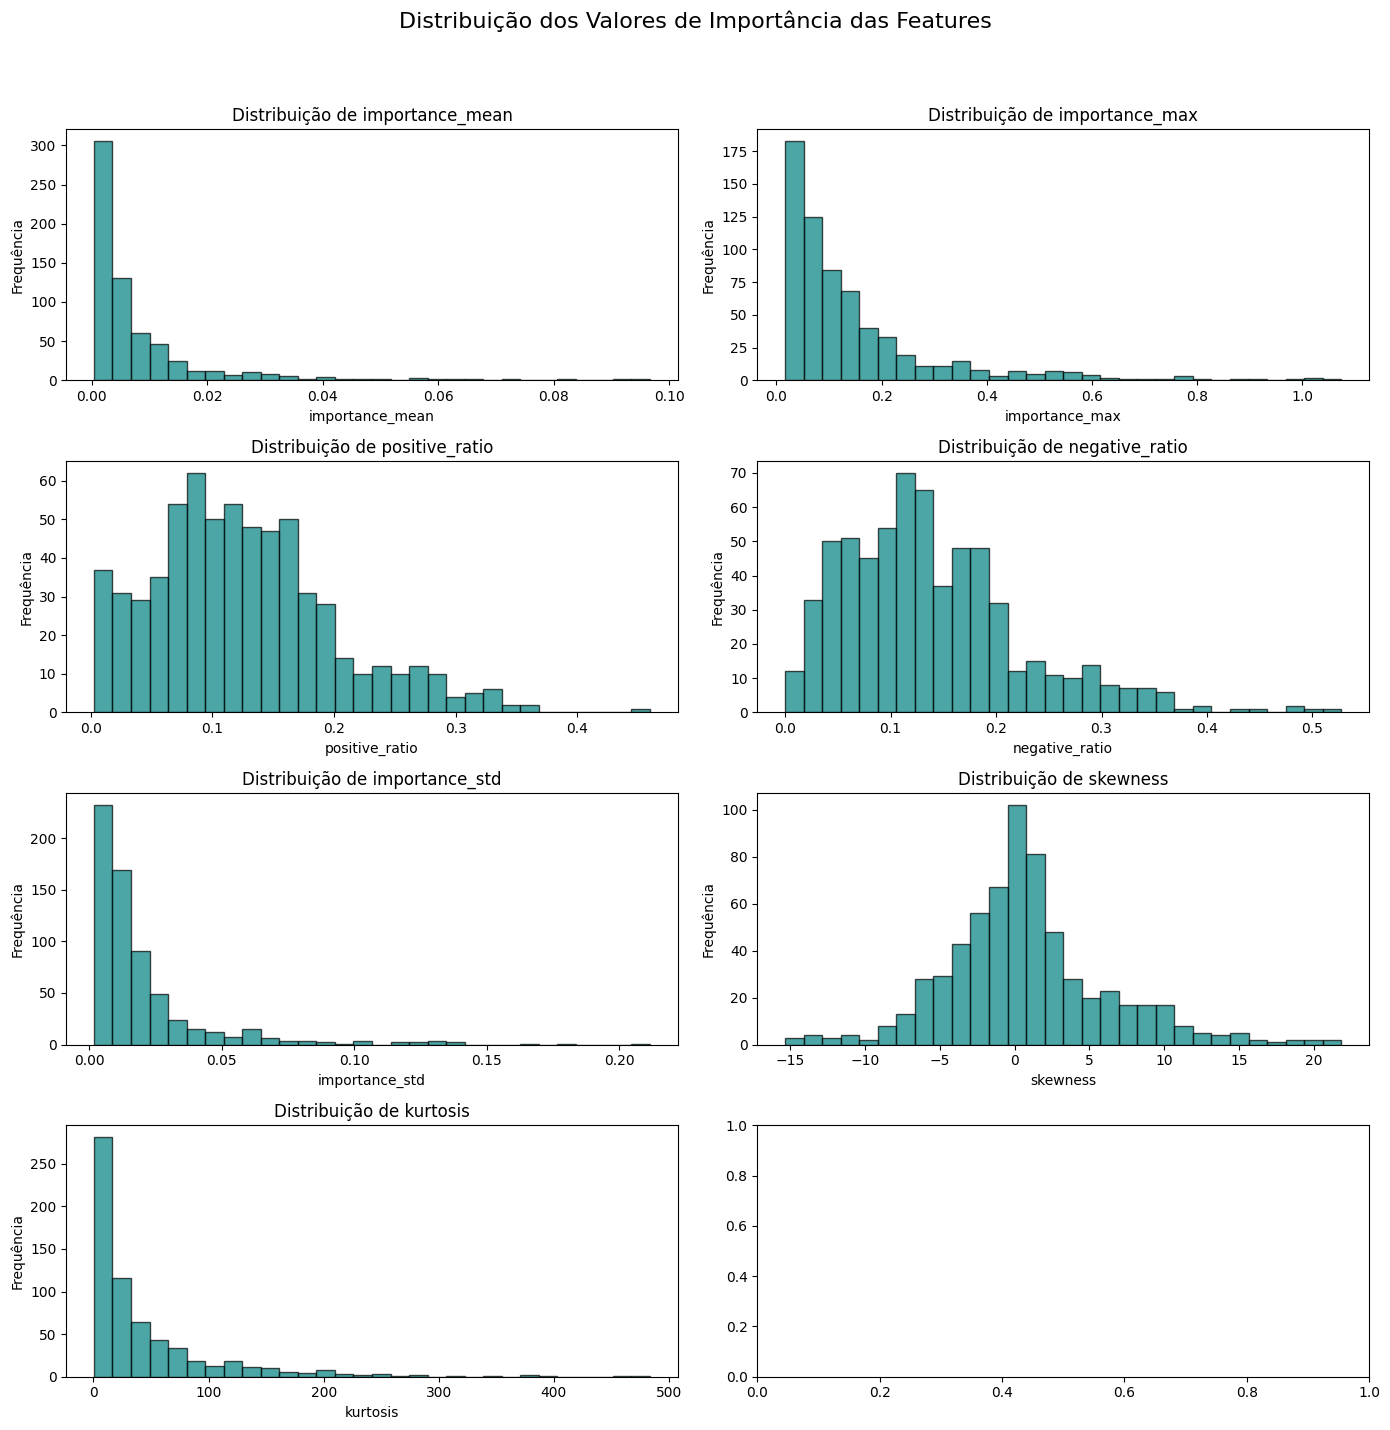

In [121]:
shap_values_df_analysis(shap_importances_df_cleaned)

## SHAP Rules

- positive_ratio < small_threshold & negative_ratio > big_threhsold
- positive_ratio < small_threshold & importance_mean < small_threshold
- importance_max < small_threshold
- importance_mean < small_threshold
- importance_max < small_threshold & importance_mean < small_threshold
- importance_std > big_threhsold & importance_mean < small_threshold
- importance_max < small_threshold & negative_ratio > big_threhsold
- importance_mean < small_threshold & importance_std < small_threshold
- skewness < -0.5 & kurtosis > 3
- skewness < 0 & positive_ratio < small_threshold

In [149]:
main_rule1 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_max"] < 0.075)
    ]["feature"].tolist()
print("MainRule1: ",len(main_rule1))

main_rule2 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_mean"] < 0.005)
    ]["feature"].tolist()
print("MainRule2: ",len(main_rule2))

combined_main_rules = list(set(main_rule1 + main_rule2))
print(len(combined_main_rules))

rule1 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["positive_ratio"] < 0.3) & 
        (shap_importances_df_cleaned["negative_ratio"] > 0.5) 
    ]["feature"].tolist()
print("Rule1: ",len(rule1))

rule2 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["positive_ratio"] < 0.05) & 
        (shap_importances_df_cleaned["importance_mean"] < 0.01) 
    ]["feature"].tolist()
print("Rule2: ",len(rule2))

rule3 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["skewness"] < -1.5) & 
        (shap_importances_df_cleaned["kurtosis"] > 40)
    ]["feature"].tolist()
print("Rule3: ",len(rule3))

rule4 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_max"] < 0.1) & 
        (shap_importances_df_cleaned["importance_mean"] < 0.01)
    ]["feature"].tolist()
print("Rule4: ",len(rule4))

rule5 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_std"] > 0.19) & 
        (shap_importances_df_cleaned["importance_mean"] < 0.05)
    ]["feature"].tolist()
print("Rule5: ",len(rule5))

rule6 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_max"] < 0.5) & 
        (shap_importances_df_cleaned["negative_ratio"] >  0.4)
    ]["feature"].tolist()
print("Rule6: ",len(rule6))

rule7 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_std"] < 0.015) & 
        (shap_importances_df_cleaned["importance_mean"] < 0.01)
    ]["feature"].tolist()
print("Rule7: ",len(rule7))

rule8 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["positive_ratio"] < 0.15) & 
        (shap_importances_df_cleaned["negative_ratio"] > 0.45) 
    ]["feature"].tolist()
print("Rule8: ",len(rule8))

combined_rules = list(set(rule1 + rule2 + rule3 + rule4 + rule5 + rule6 + rule7))
print(len(combined_rules))

MainRule1:  0
MainRule2:  0
0
Rule1:  1
Rule2:  8
Rule3:  12
Rule4:  17
Rule5:  0
Rule6:  4
Rule7:  18
Rule8:  2
48


In [151]:
shap_train_df = shap_train_df.drop(columns=combined_main_rules, errors="ignore")
shap_control_df = shap_control_df.drop(columns=combined_main_rules, errors="ignore")
shap_test_df = shap_test_df.drop(columns=combined_main_rules, errors="ignore")
shap_train_df.to_csv("../Dataset/train_df_without_shap_low_values.csv",index=False)
shap_importances_df_cleaned = clean_shap_df(shap_importances_df_cleaned,combined_main_rules)
print(shap_importances_df_cleaned.shape)

(233, 8)


In [152]:
shap_values = new_shap_values(shap_values,combined_main_rules)
X_shap = shap_train_df.drop("Transition_code",axis=1)
shap_values.shape

(305, 233, 5)

In [153]:
print(shap_importances_df_cleaned.shape)
print(shap_importances_df_cleaned.describe())

(233, 8)
       importance_mean  importance_max  importance_std  positive_ratio  \
count       233.000000      233.000000      233.000000      233.000000   
mean          0.017571        0.267313        0.039291        0.163932   
std           0.015765        0.199716        0.031558        0.082703   
min           0.005026        0.076544        0.008892        0.012459   
25%           0.007489        0.125689        0.020055        0.101639   
50%           0.012021        0.202575        0.027307        0.154754   
75%           0.020608        0.342494        0.047206        0.208525   
max           0.096688        1.074082        0.211539        0.459672   

       negative_ratio    skewness    kurtosis  
count      233.000000  233.000000  233.000000  
mean         0.170520    0.112212   23.833991  
std          0.099520    3.681991   30.757646  
min          0.020328   -9.050628    0.438256  
25%          0.096393   -2.293173    6.304868  
50%          0.151475   -0.107856   

In [154]:
shap_train_df = shap_train_df.drop(columns=combined_rules, errors="ignore")
shap_control_df = shap_control_df.drop(columns=combined_rules, errors="ignore")
shap_test_df = shap_test_df.drop(columns=combined_rules, errors="ignore")
shap_train_df.to_csv("../Dataset/train_df_without_shap_low_values.csv",index=False)
shap_importances_df_cleaned = clean_shap_df(shap_importances_df_cleaned,combined_rules)
print(shap_importances_df_cleaned.shape)

(185, 8)


In [155]:
shap_values = new_shap_values(shap_values,combined_rules)
X_shap = shap_train_df.drop("Transition_code",axis=1)
shap_values.shape

(305, 185, 5)

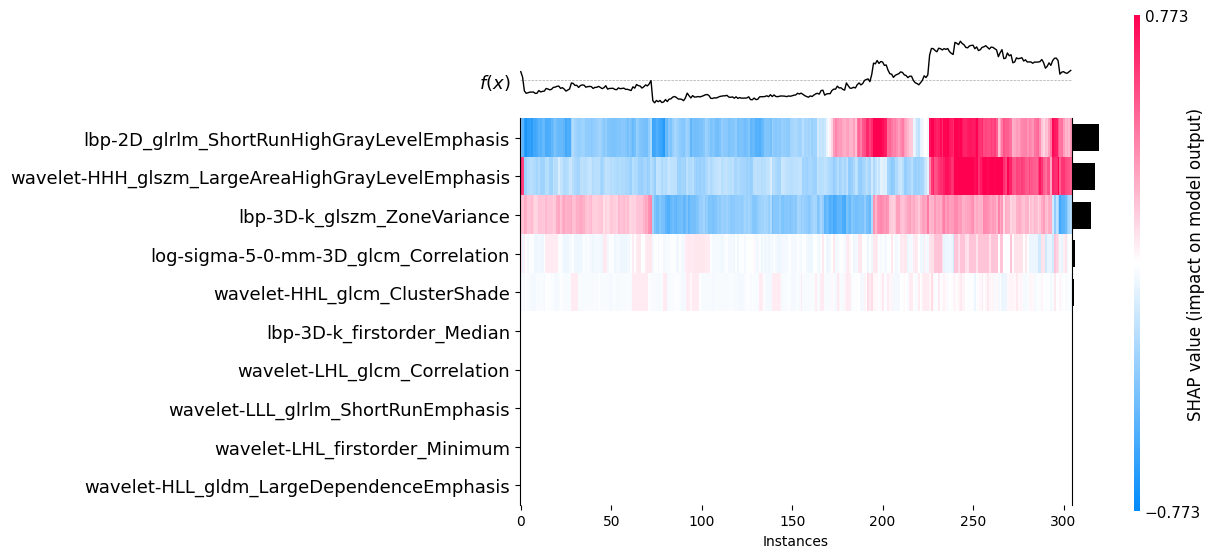

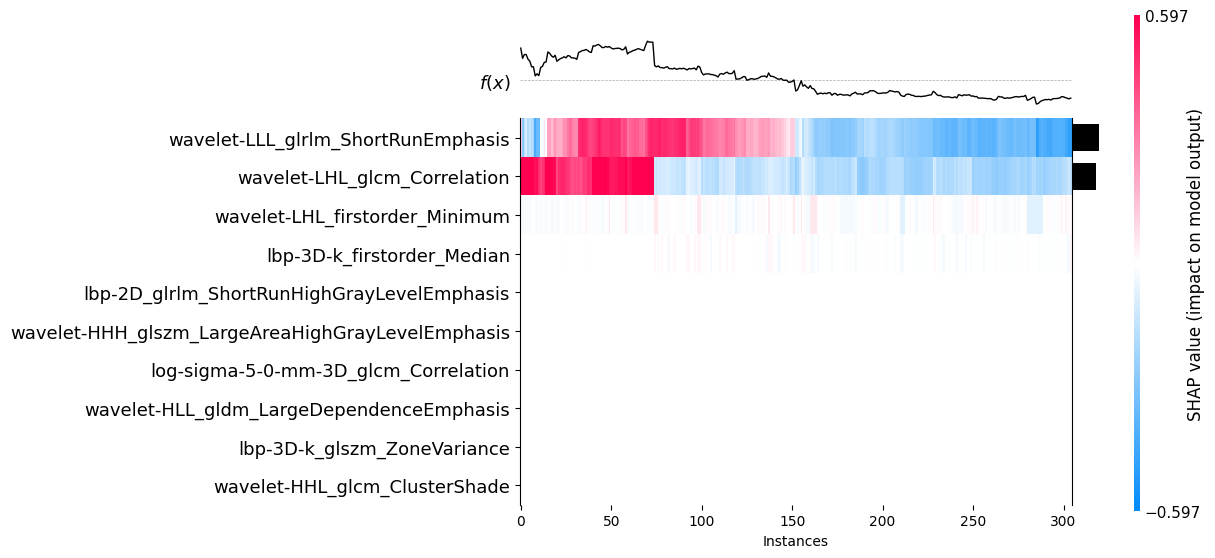

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_heatmap.py:150: RuntimeWarning: invalid value encountered in divide
  -fx / np.abs(fx).max() - 1.5,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_heatmap.py:158: RuntimeWarning: invalid value encountered in divide
  (feature_values / np.abs(feature_values).max()) * values.shape[0] / 20,


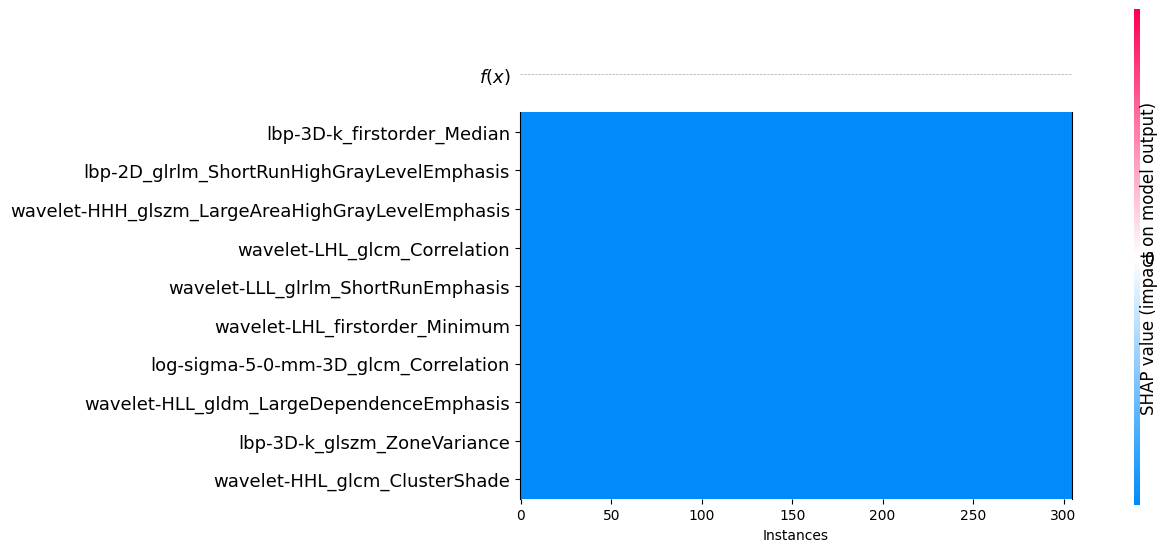

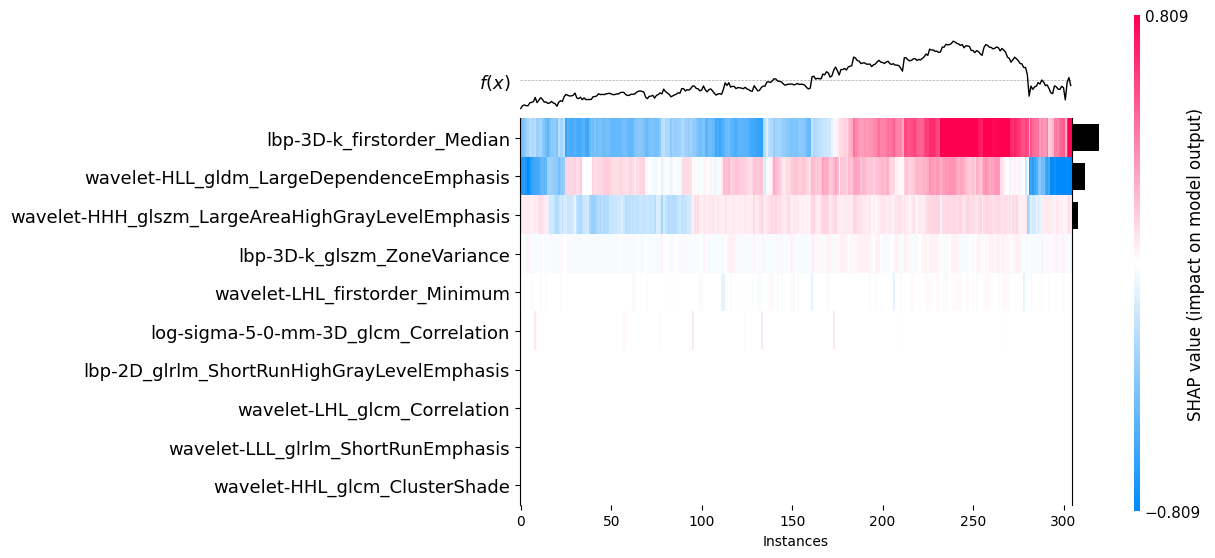

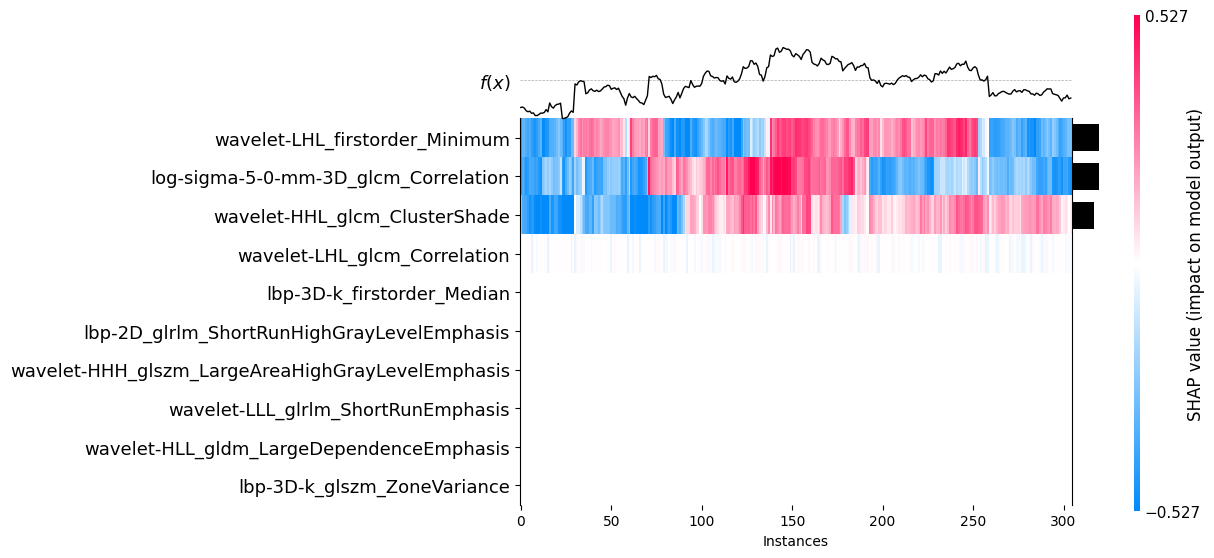

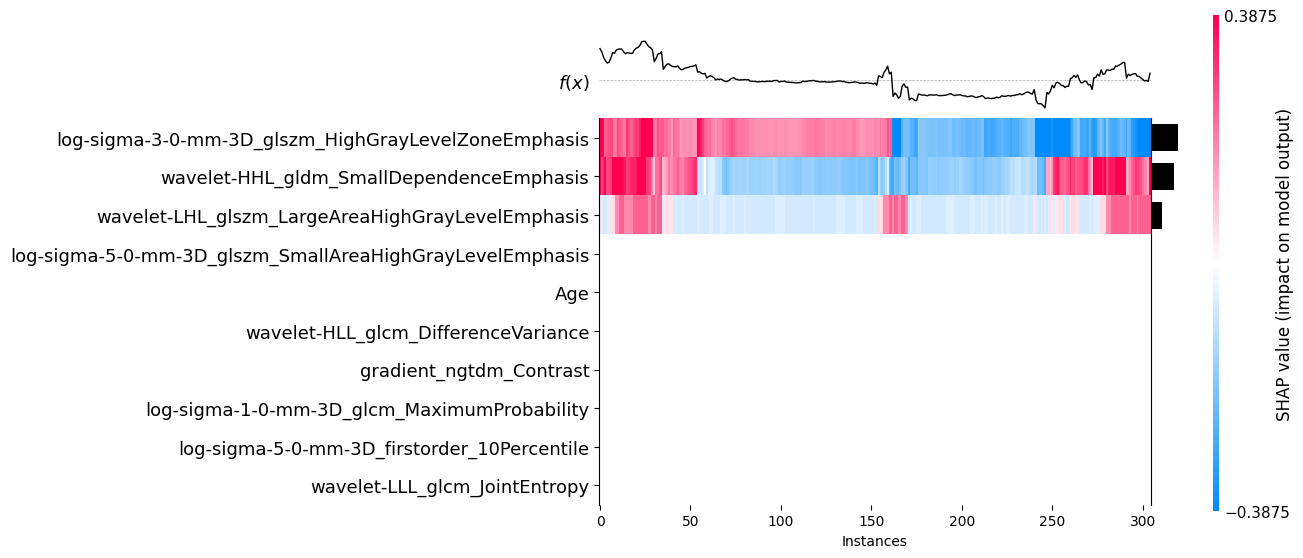

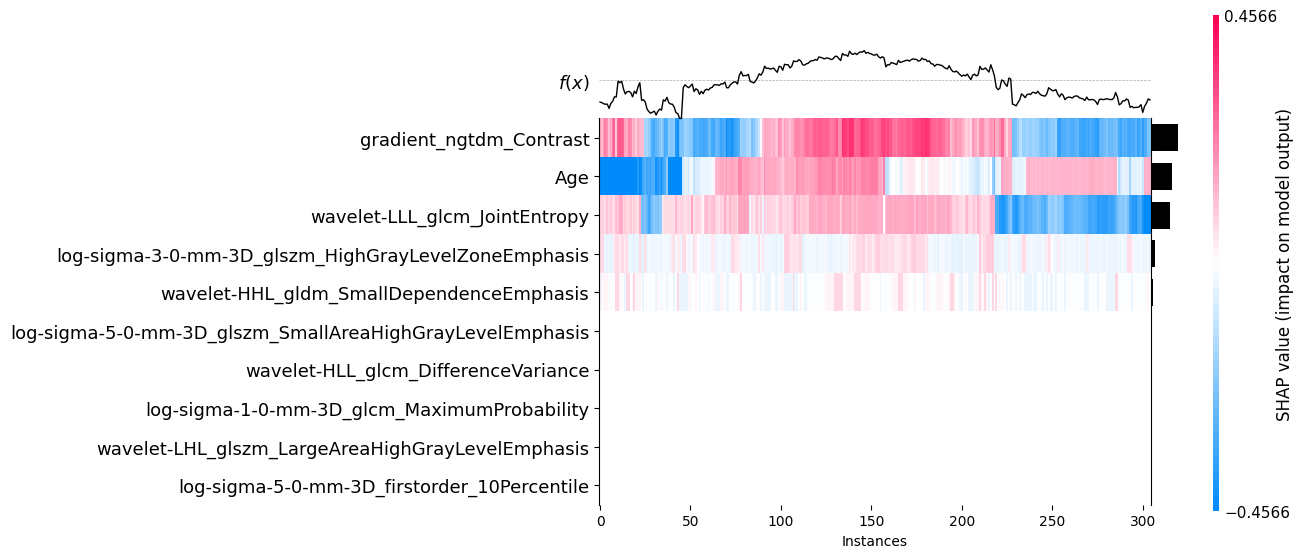

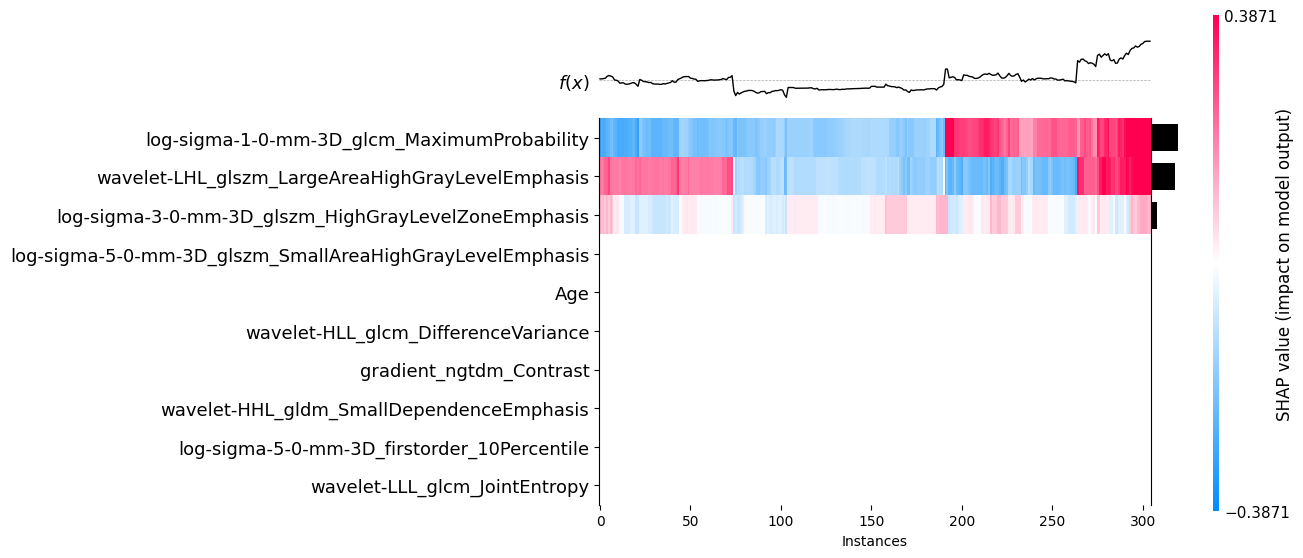

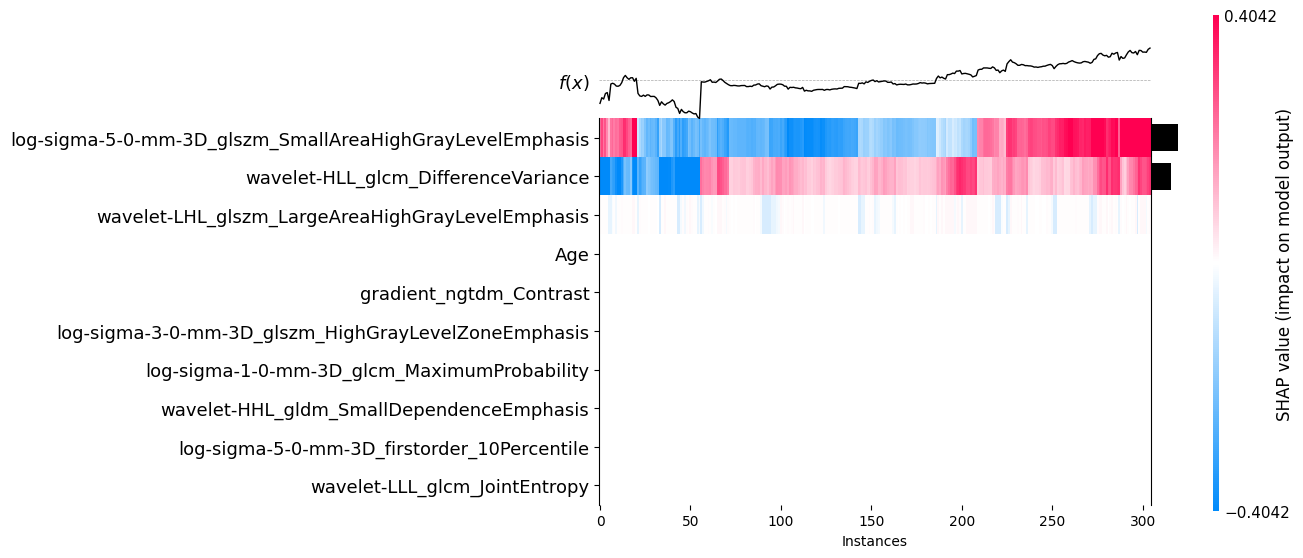

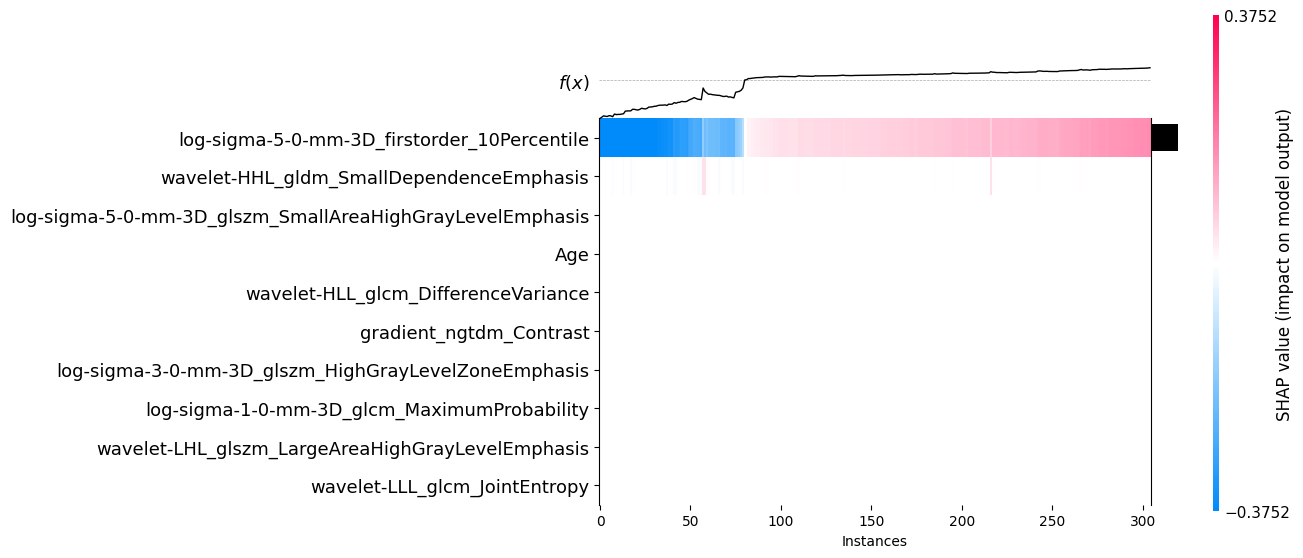

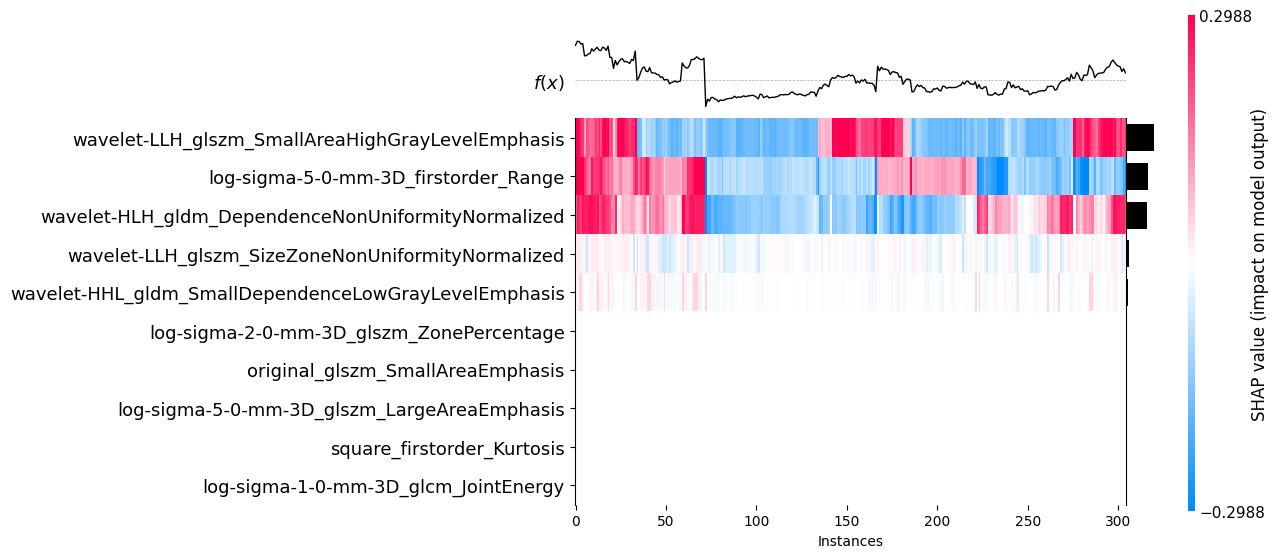

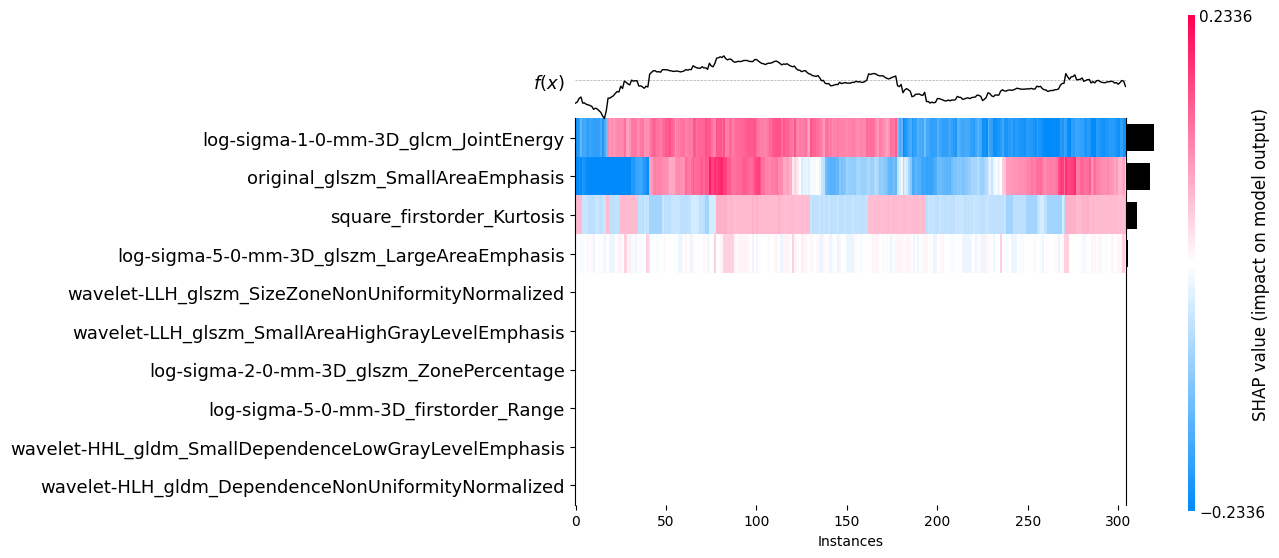

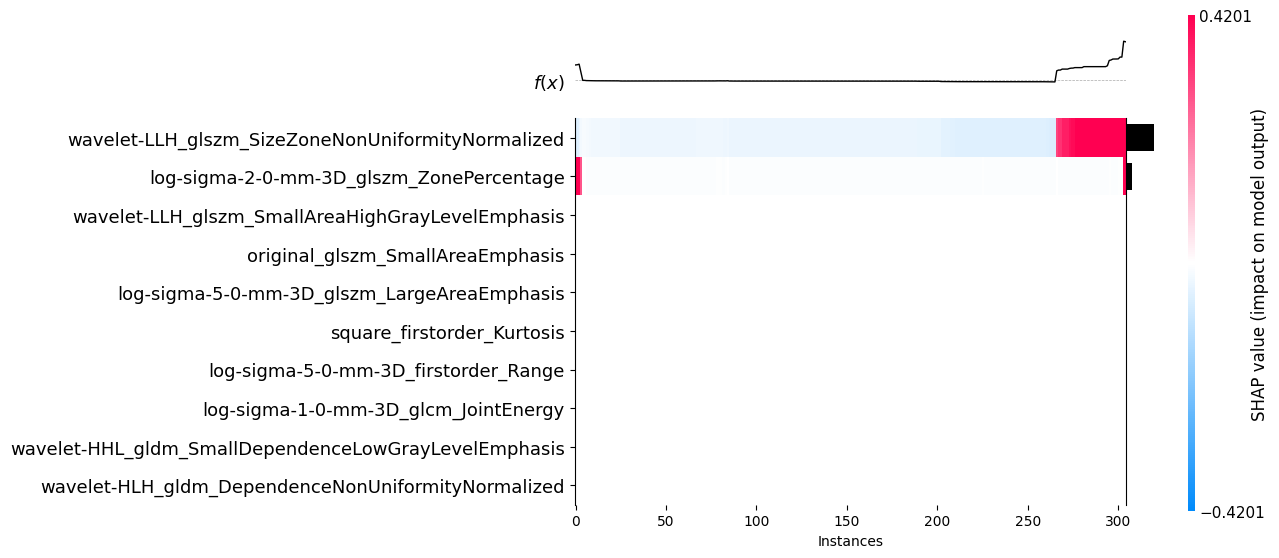

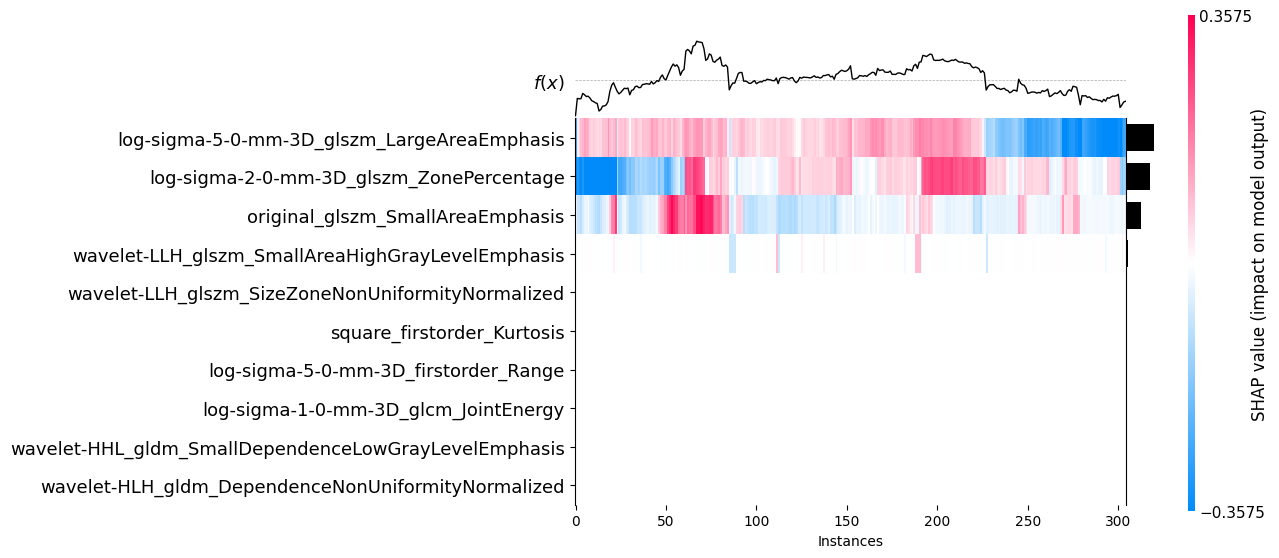

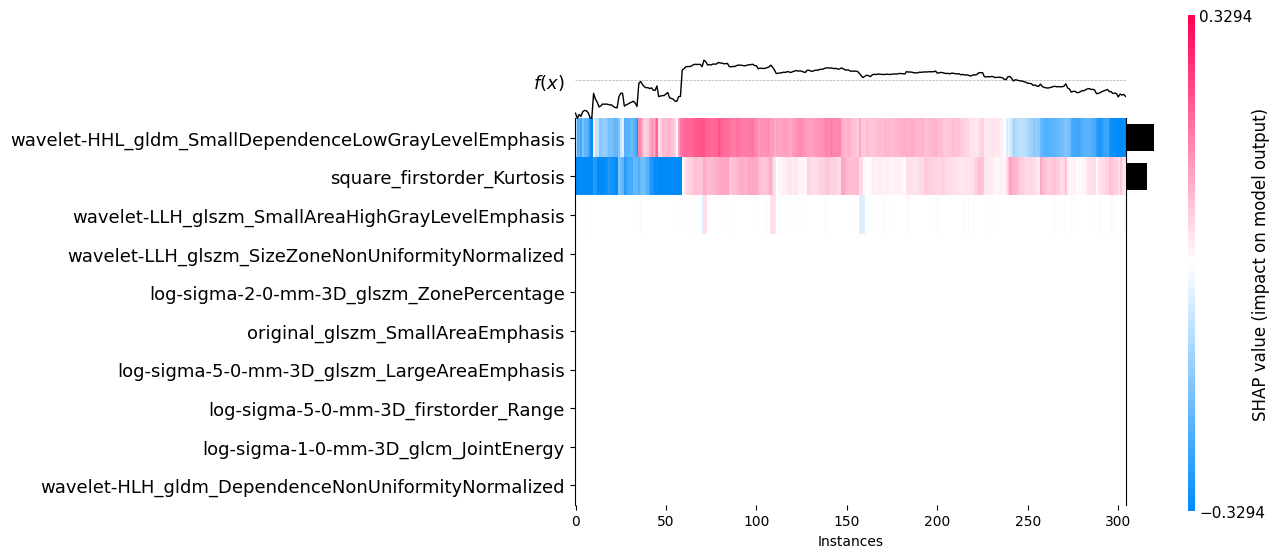

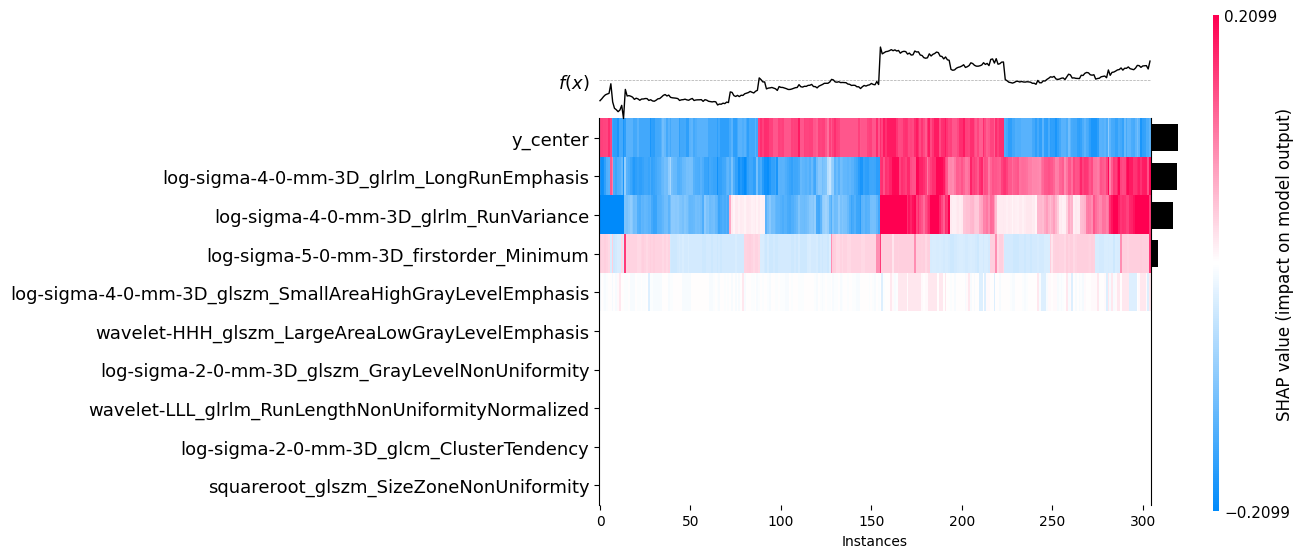

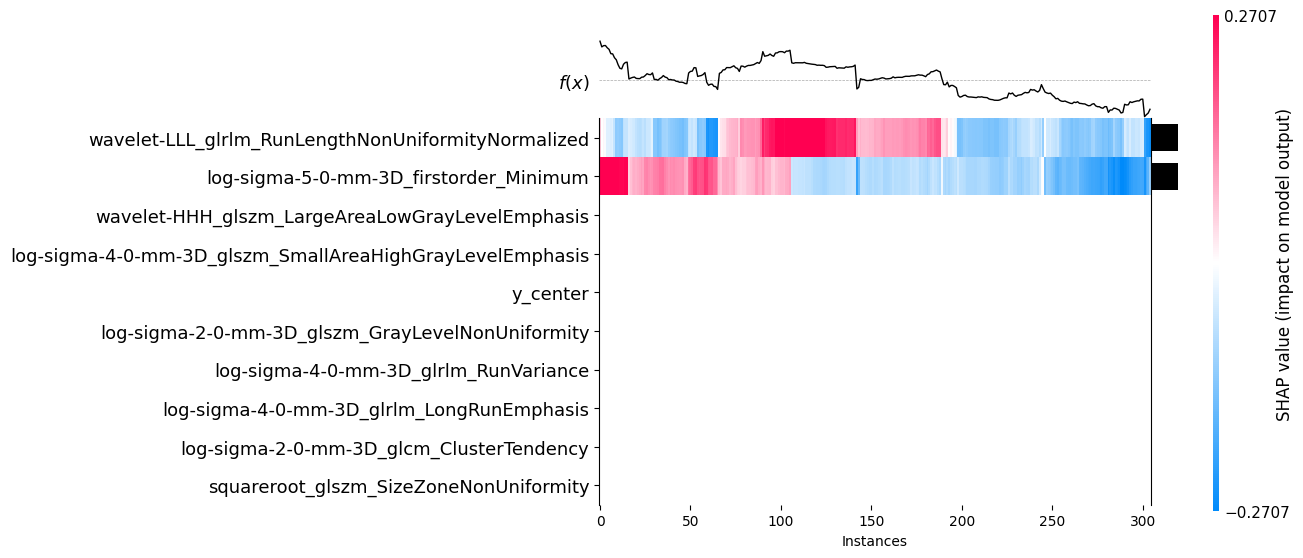

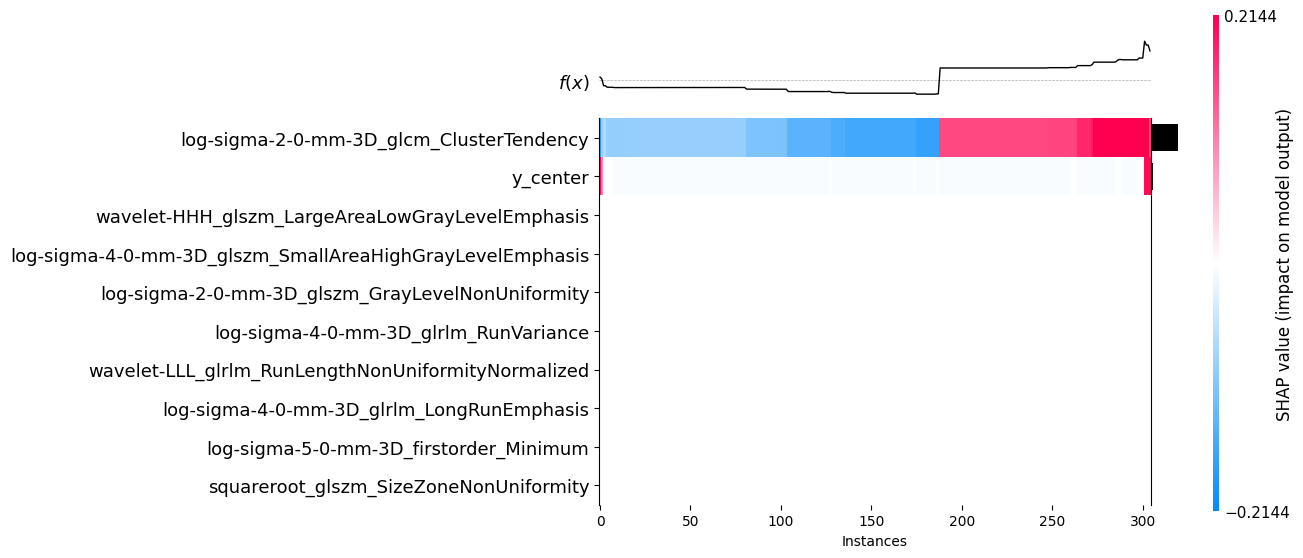

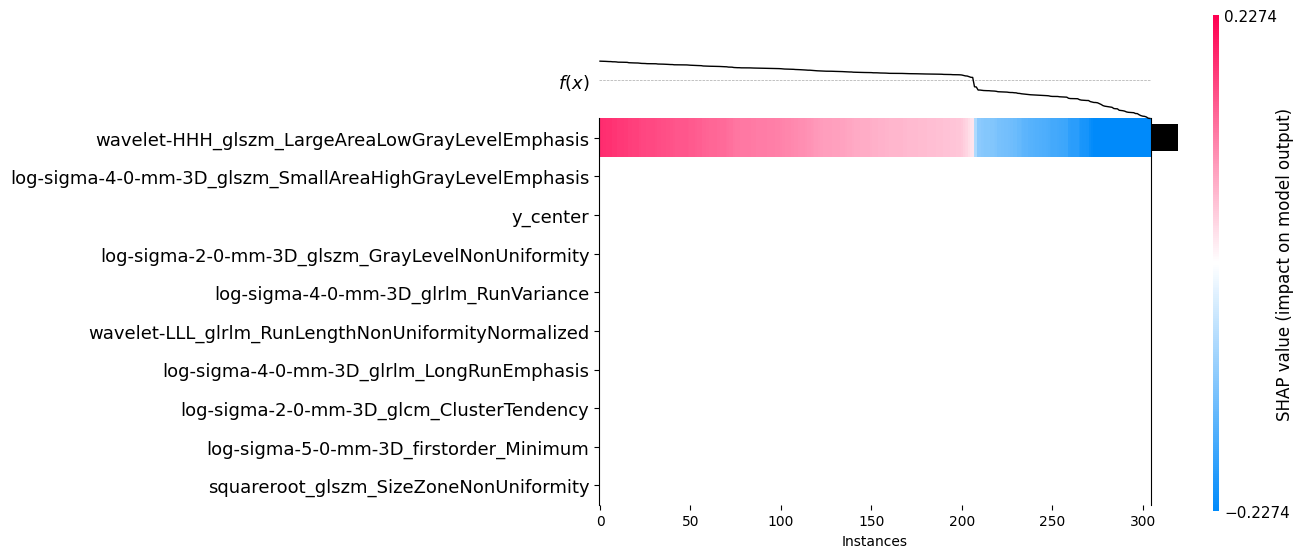

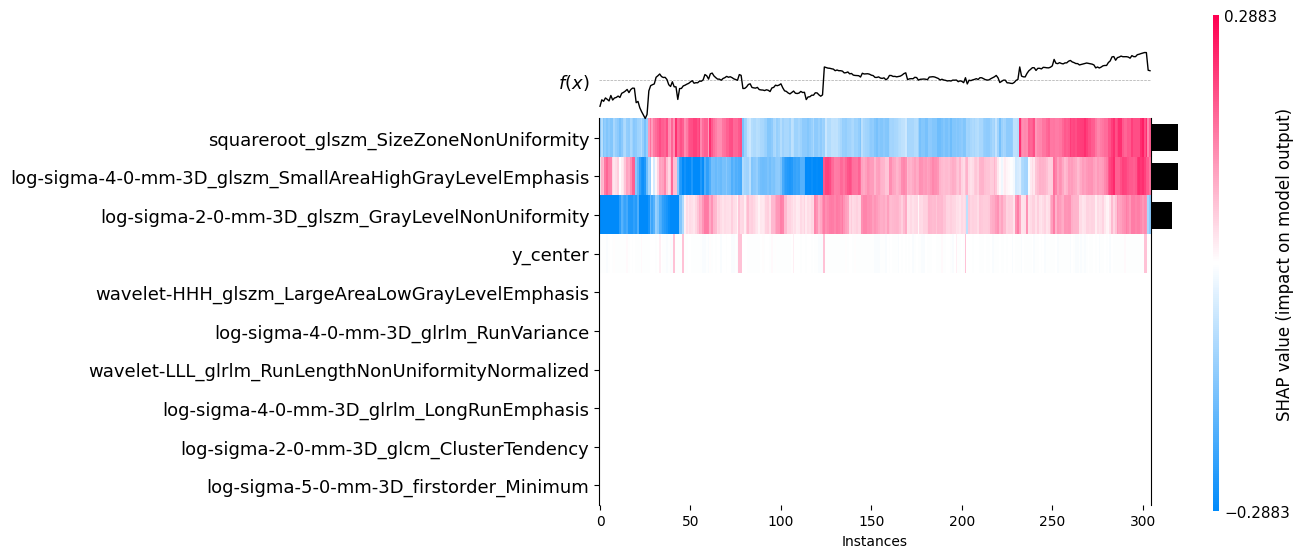

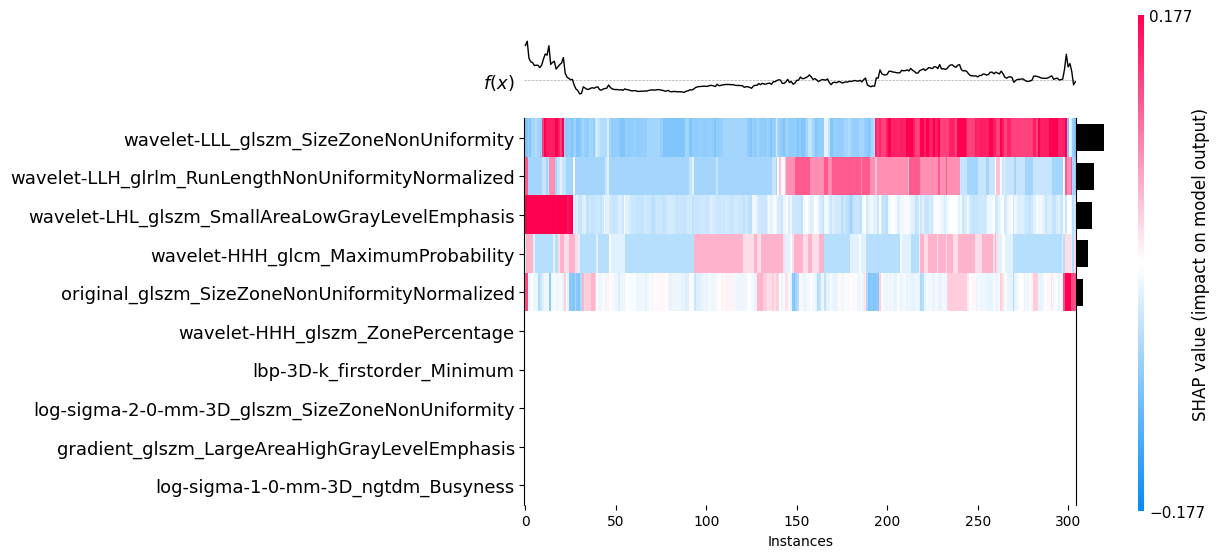

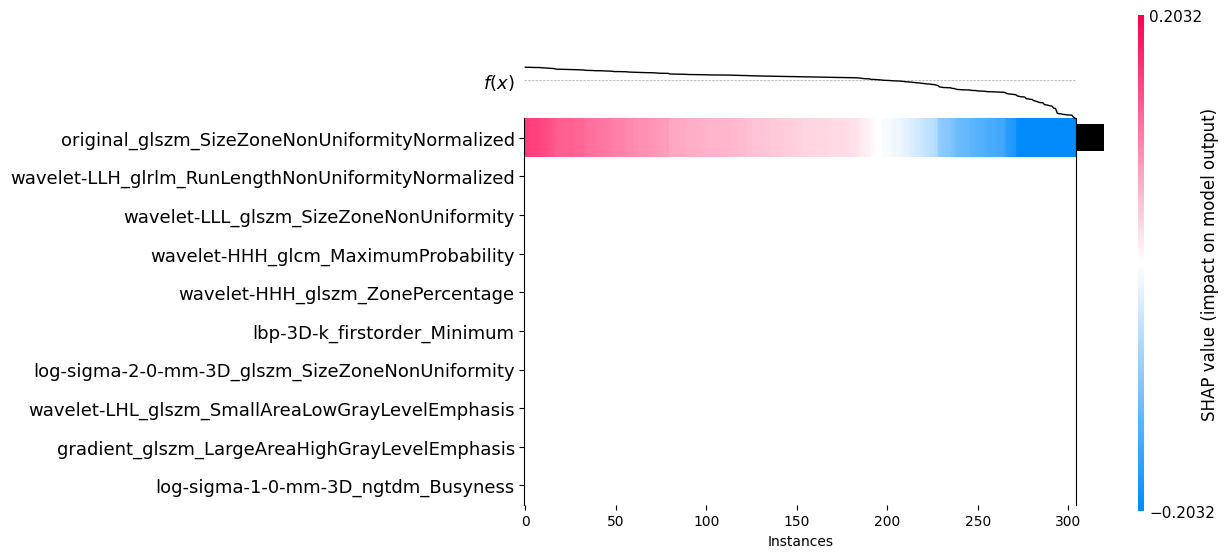

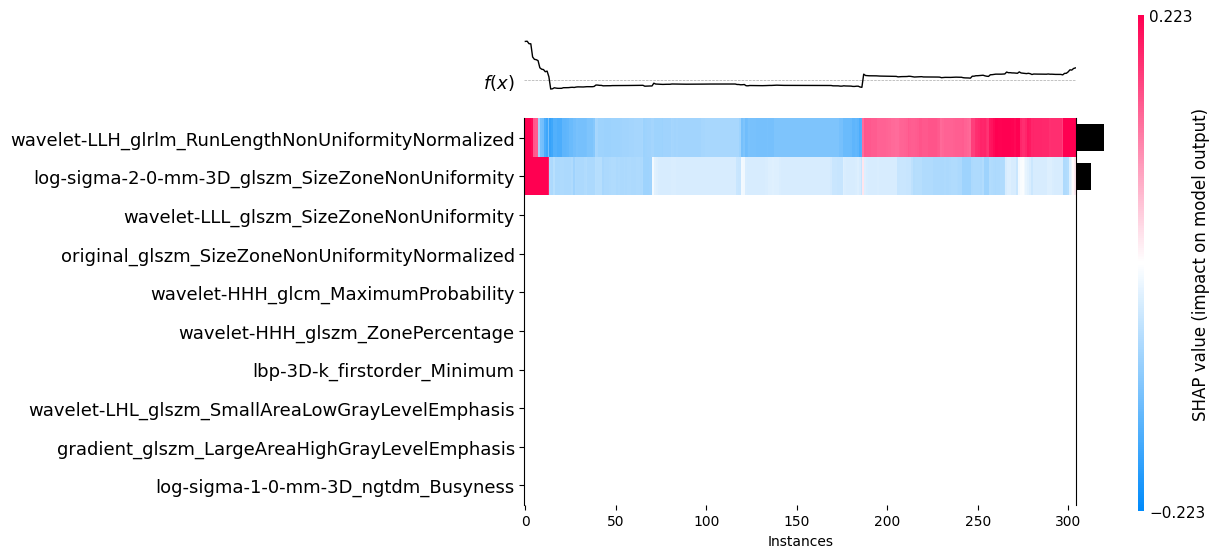

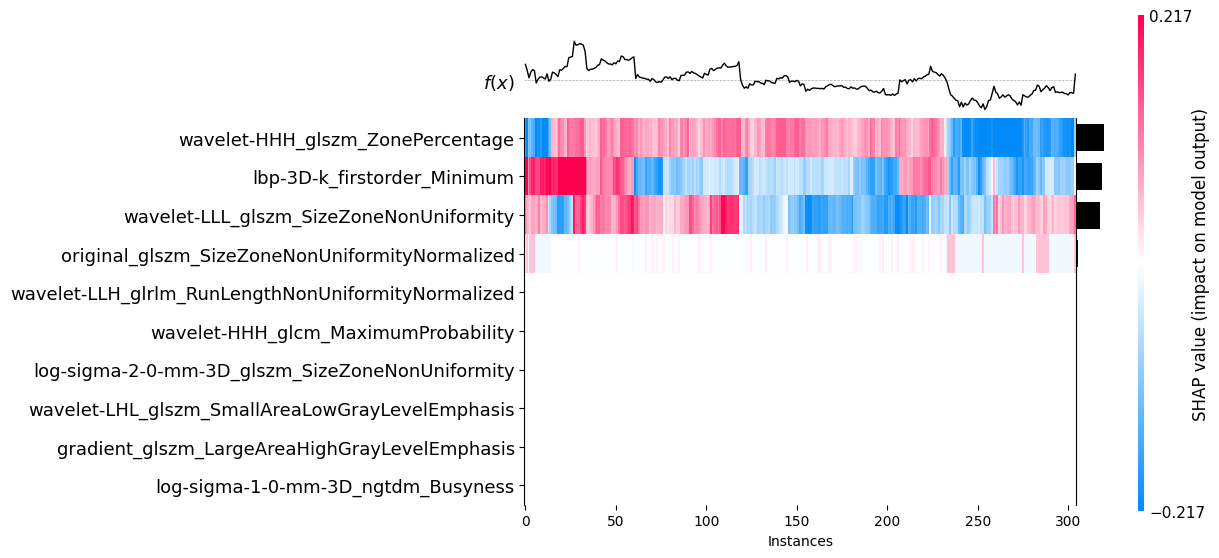

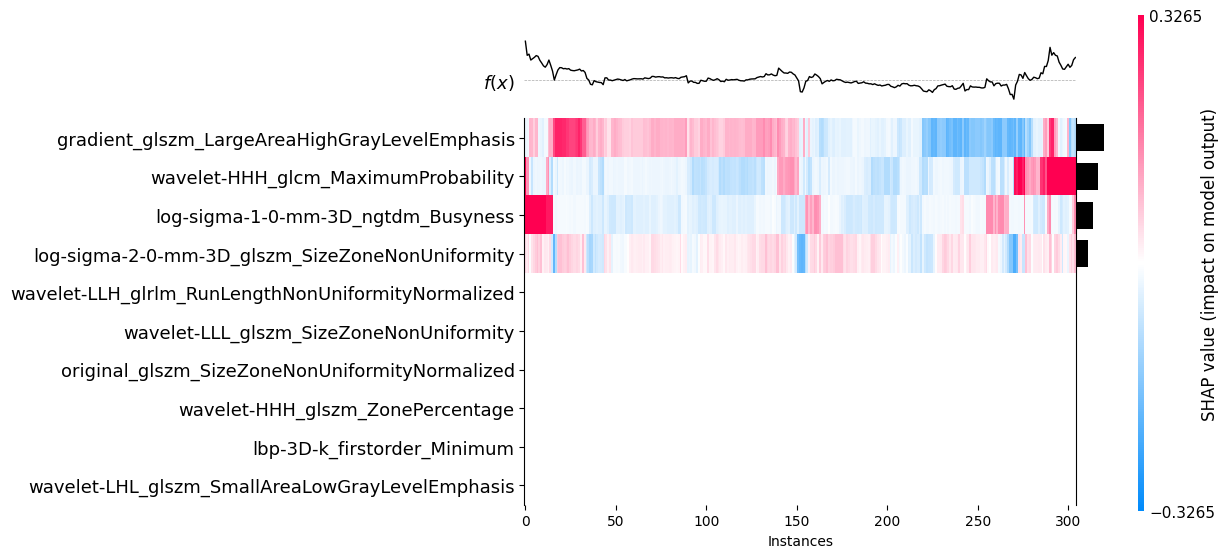

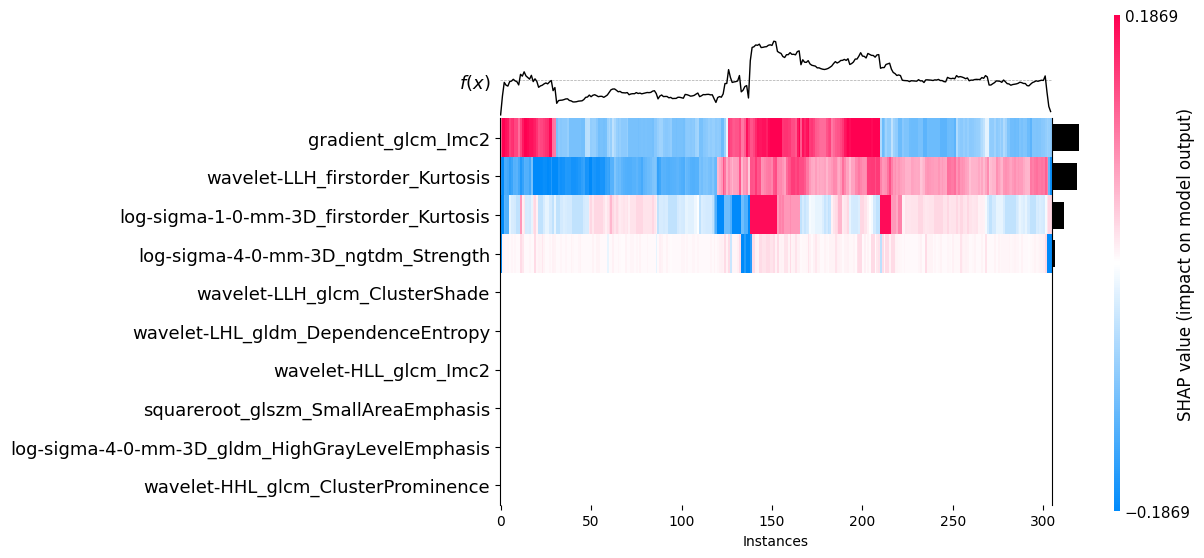

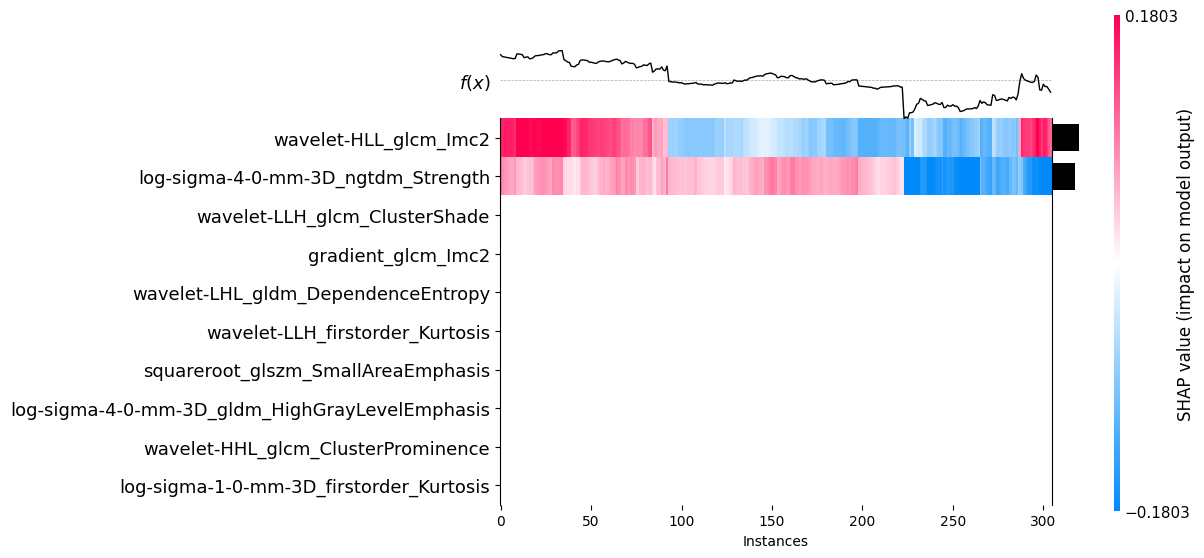

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_heatmap.py:150: RuntimeWarning: invalid value encountered in divide
  -fx / np.abs(fx).max() - 1.5,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_heatmap.py:158: RuntimeWarning: invalid value encountered in divide
  (feature_values / np.abs(feature_values).max()) * values.shape[0] / 20,


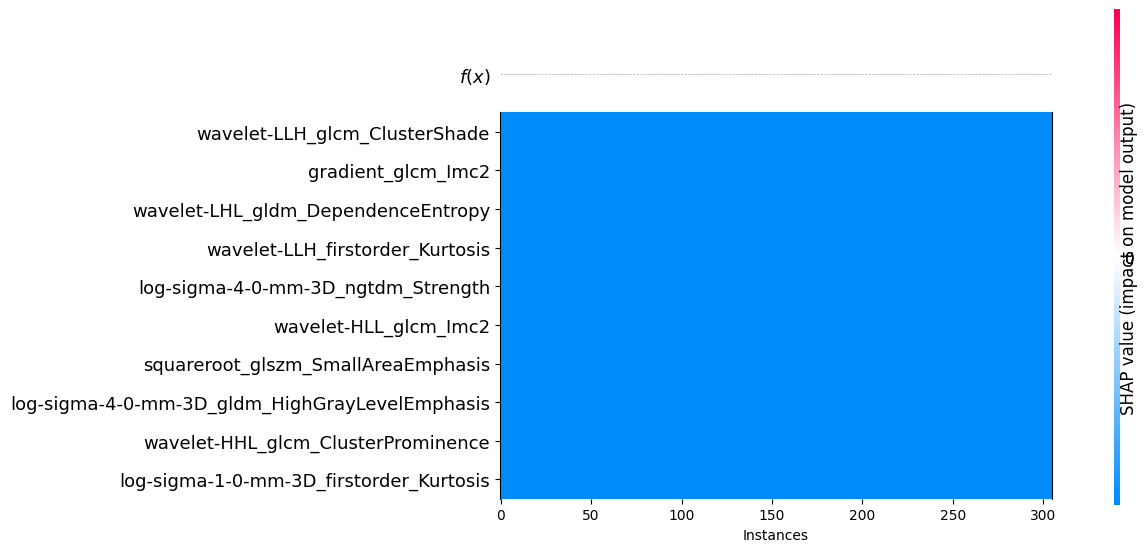

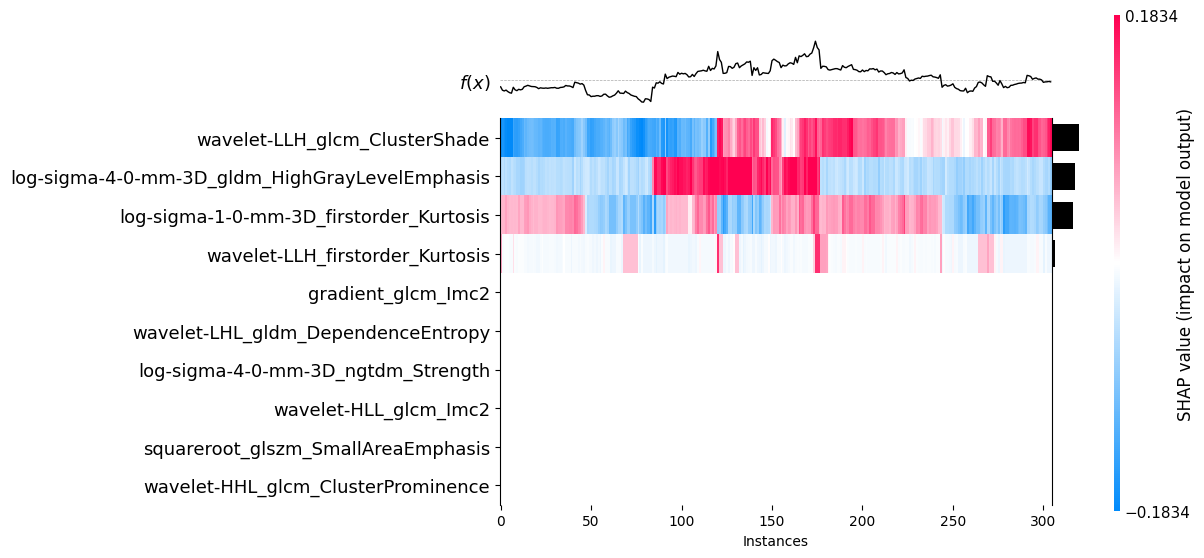

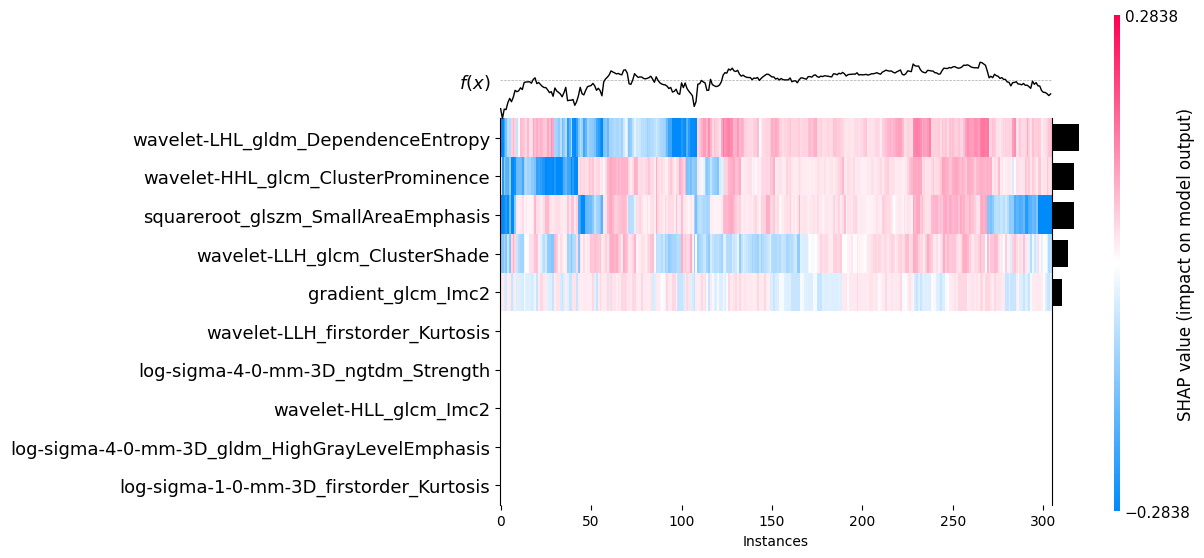

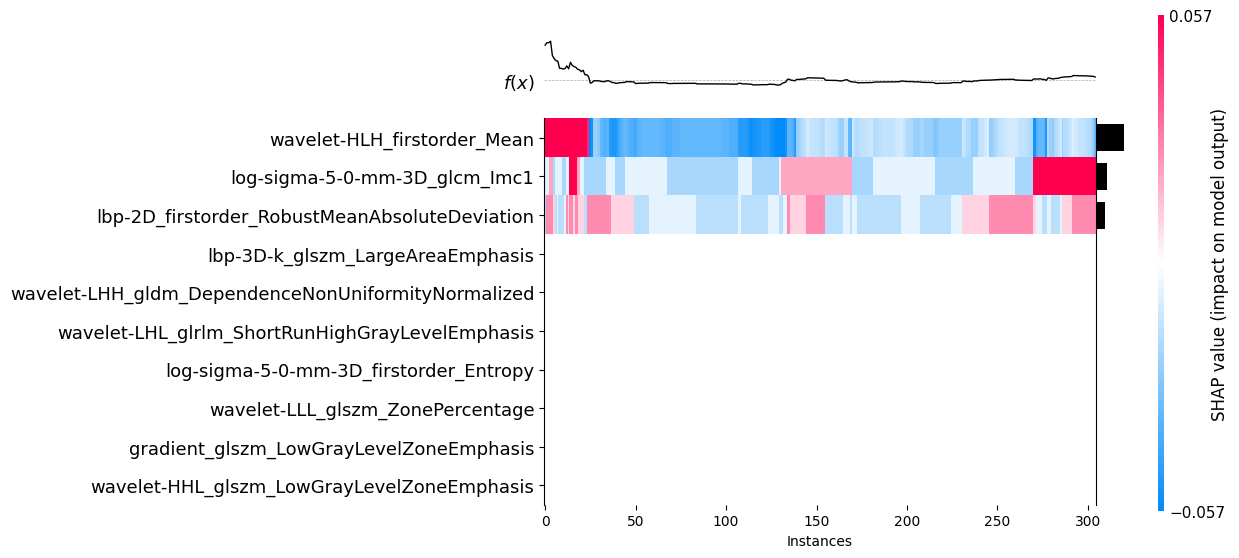

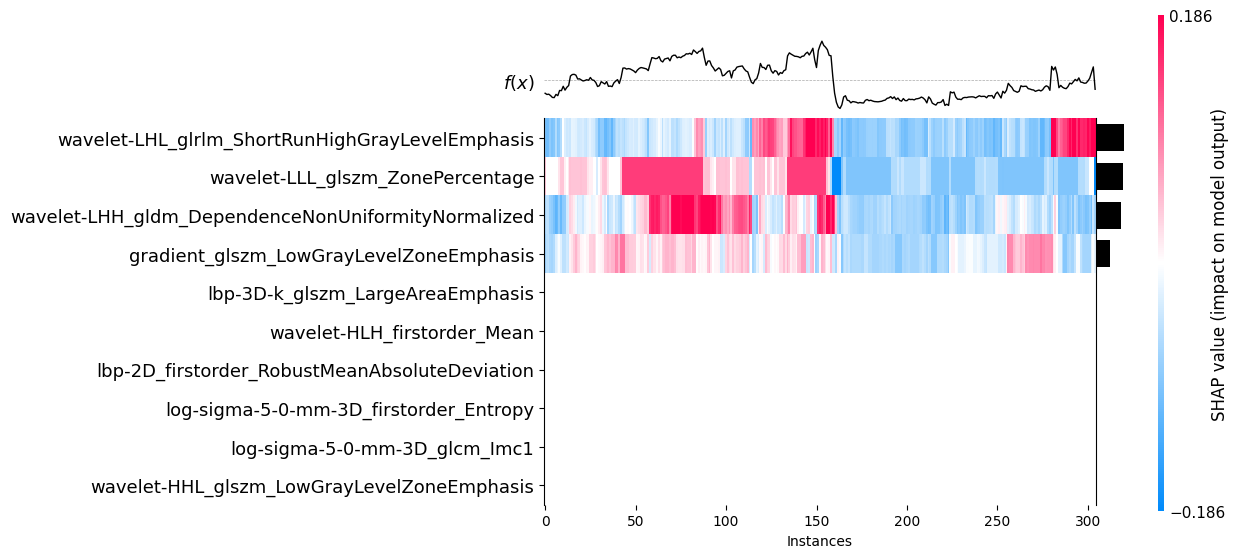

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_heatmap.py:150: RuntimeWarning: invalid value encountered in divide
  -fx / np.abs(fx).max() - 1.5,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_heatmap.py:158: RuntimeWarning: invalid value encountered in divide
  (feature_values / np.abs(feature_values).max()) * values.shape[0] / 20,


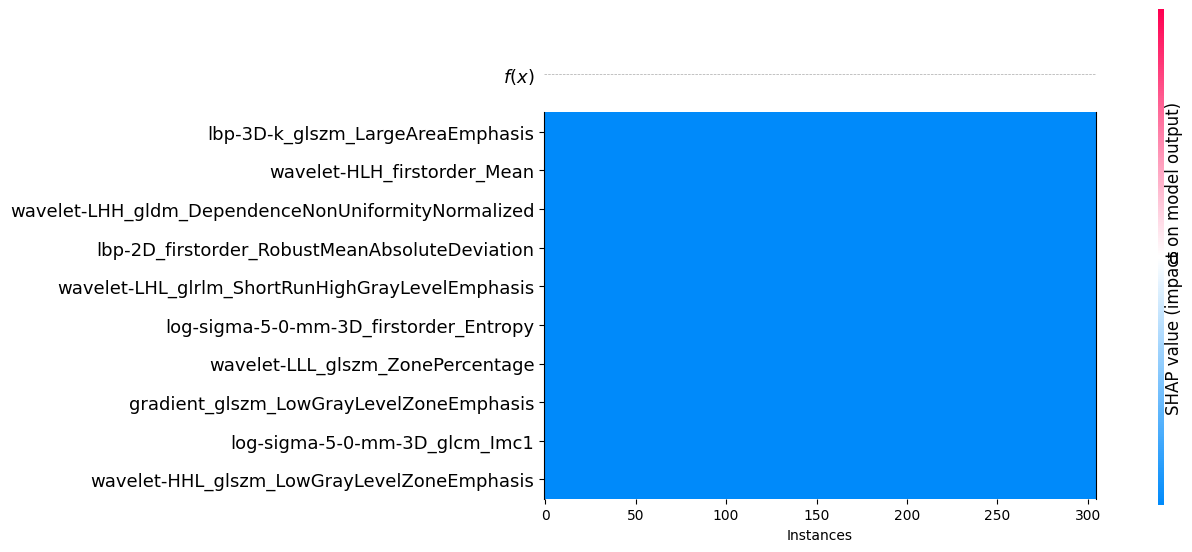

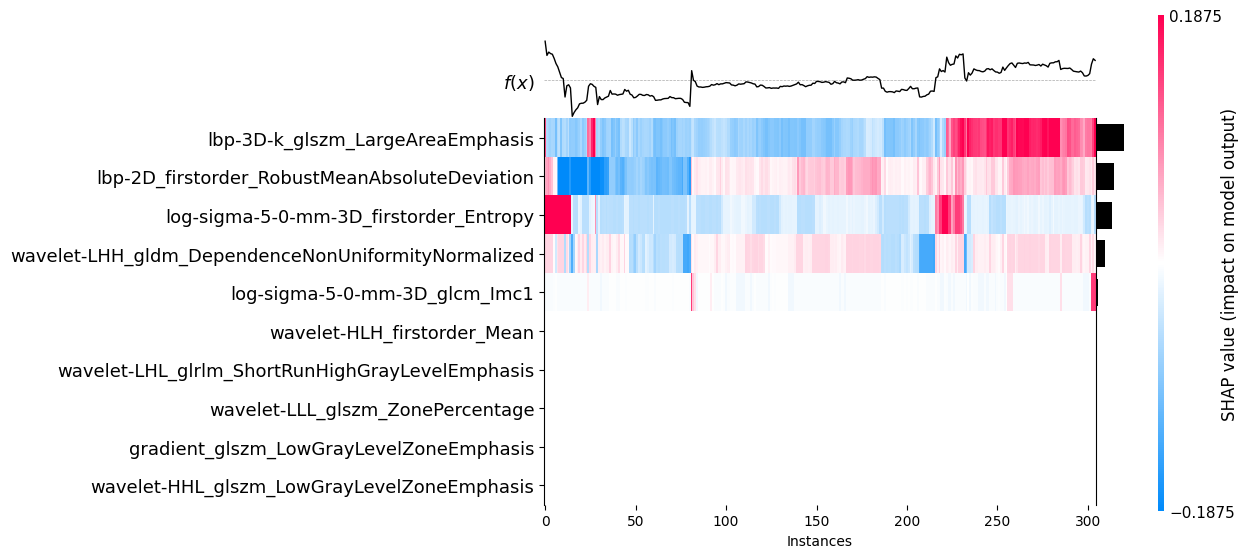

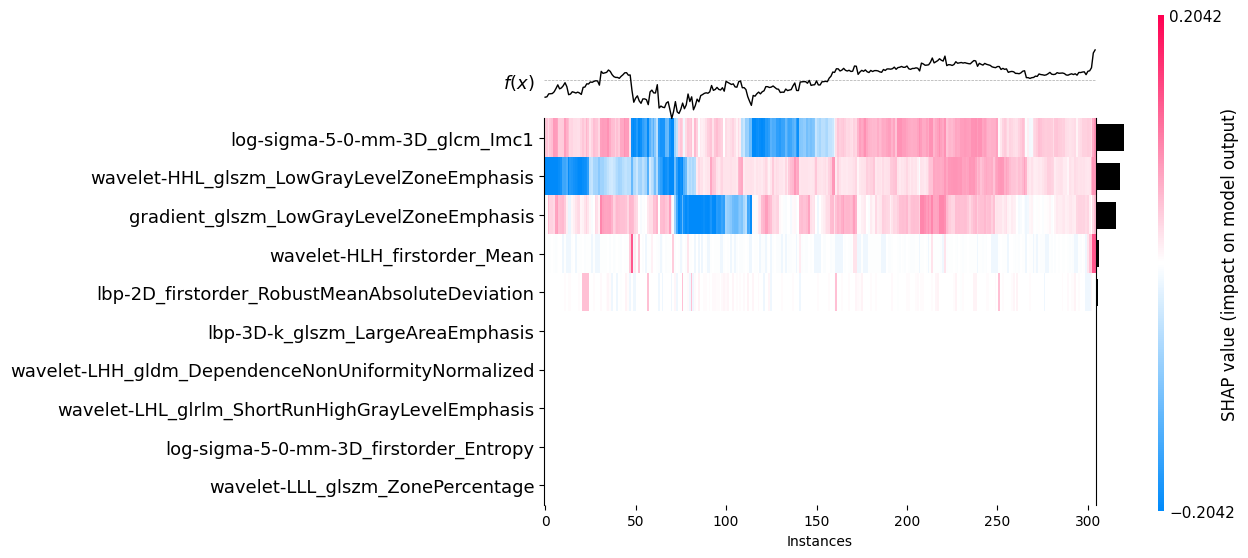

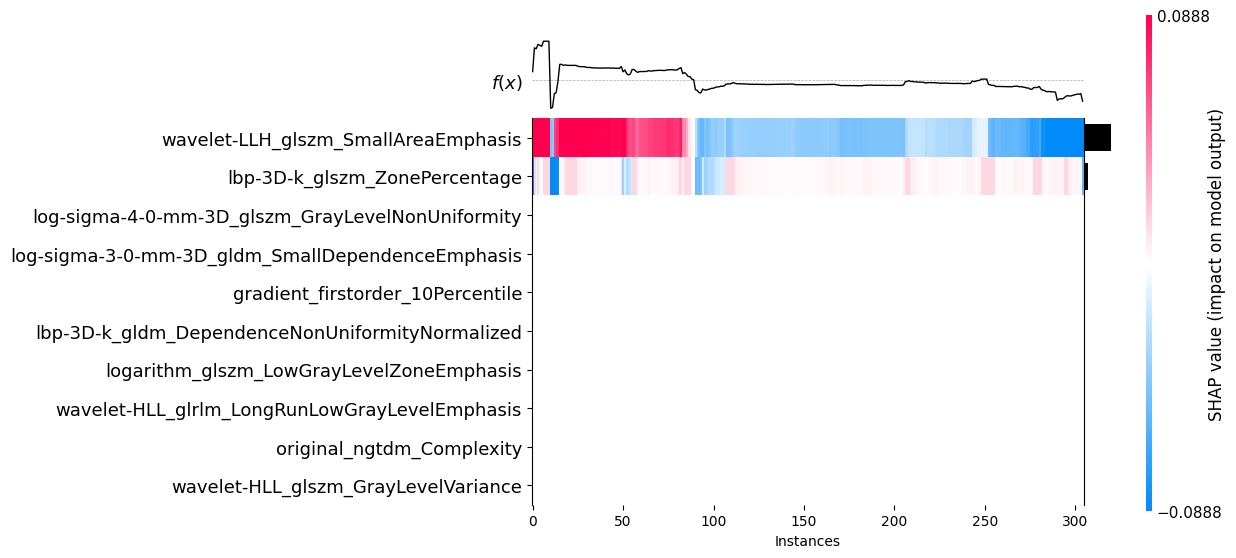

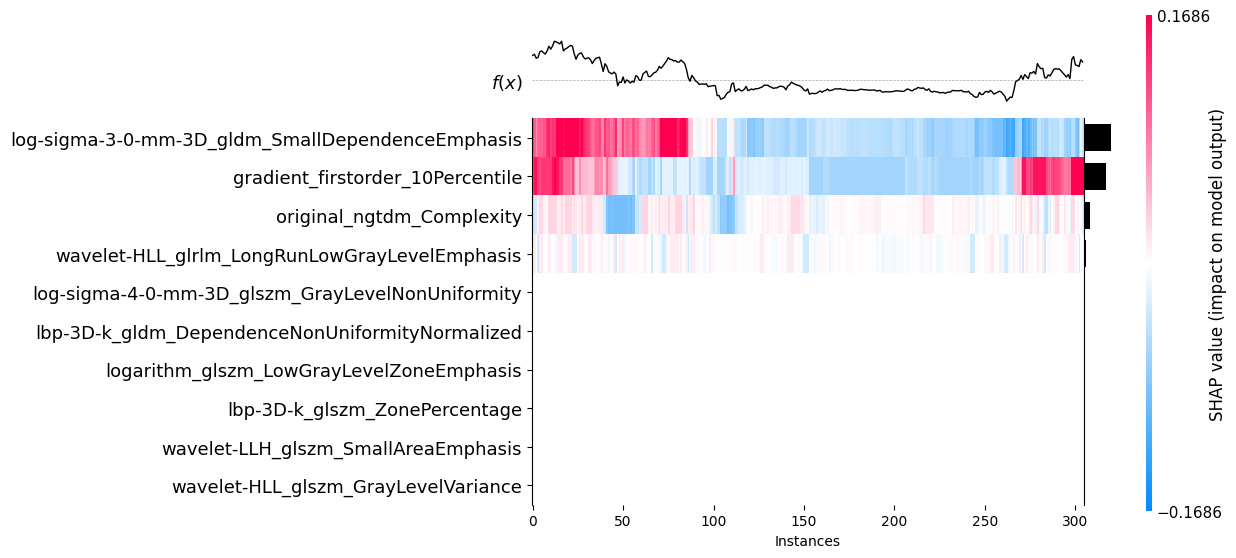

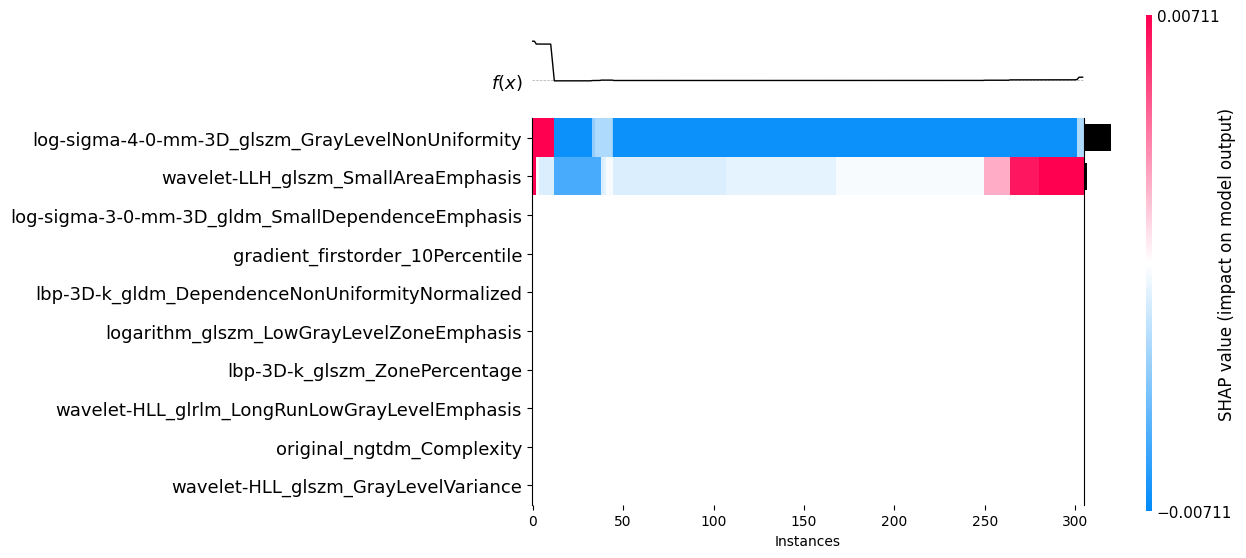

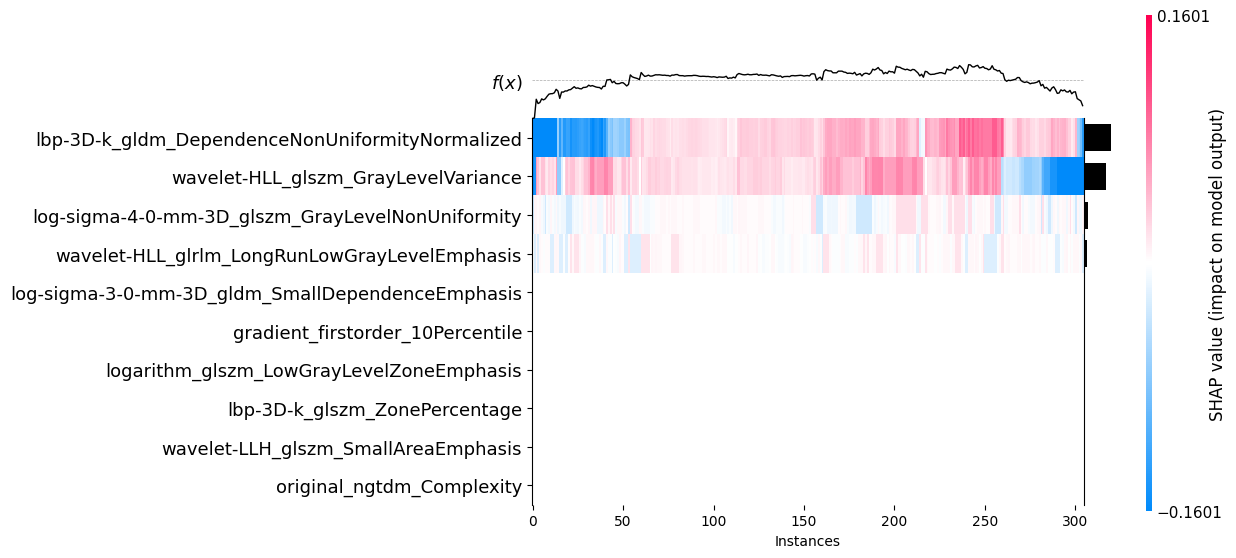

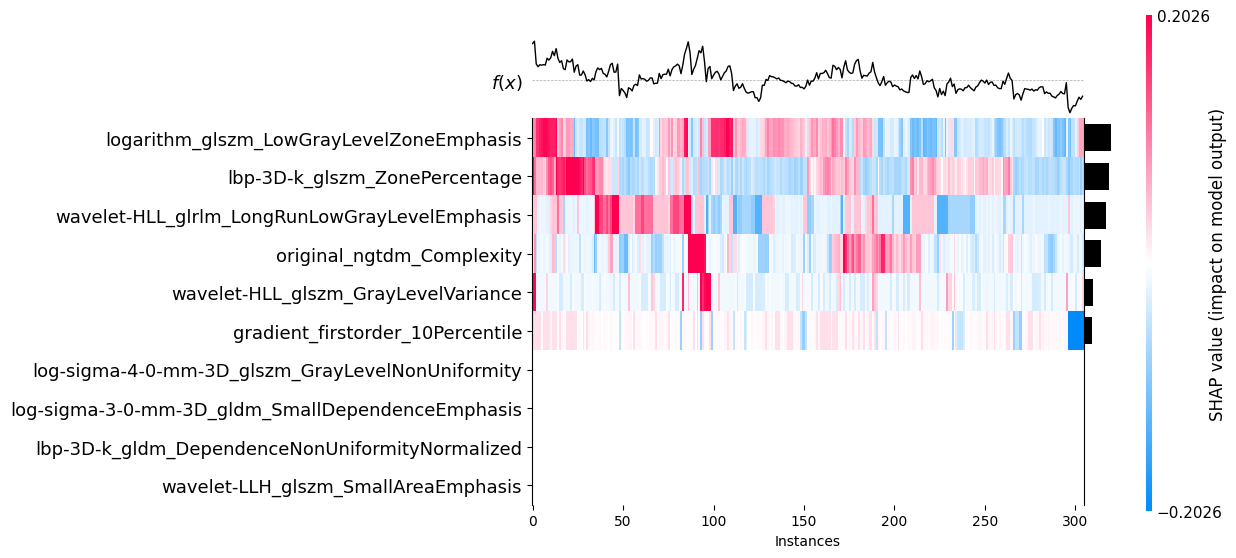

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_heatmap.py:150: RuntimeWarning: invalid value encountered in divide
  -fx / np.abs(fx).max() - 1.5,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_heatmap.py:158: RuntimeWarning: invalid value encountered in divide
  (feature_values / np.abs(feature_values).max()) * values.shape[0] / 20,


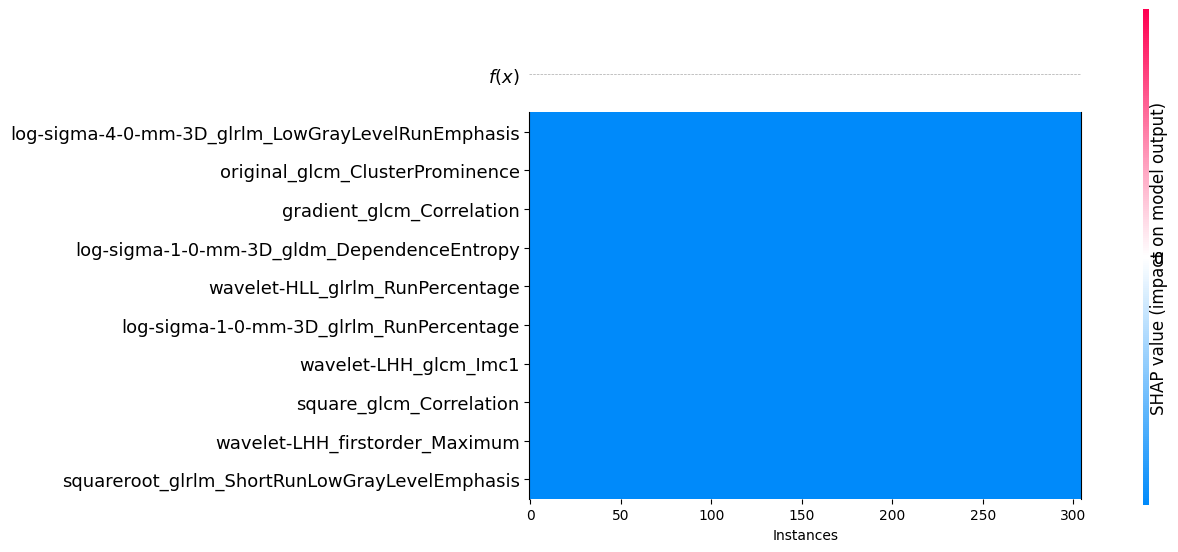

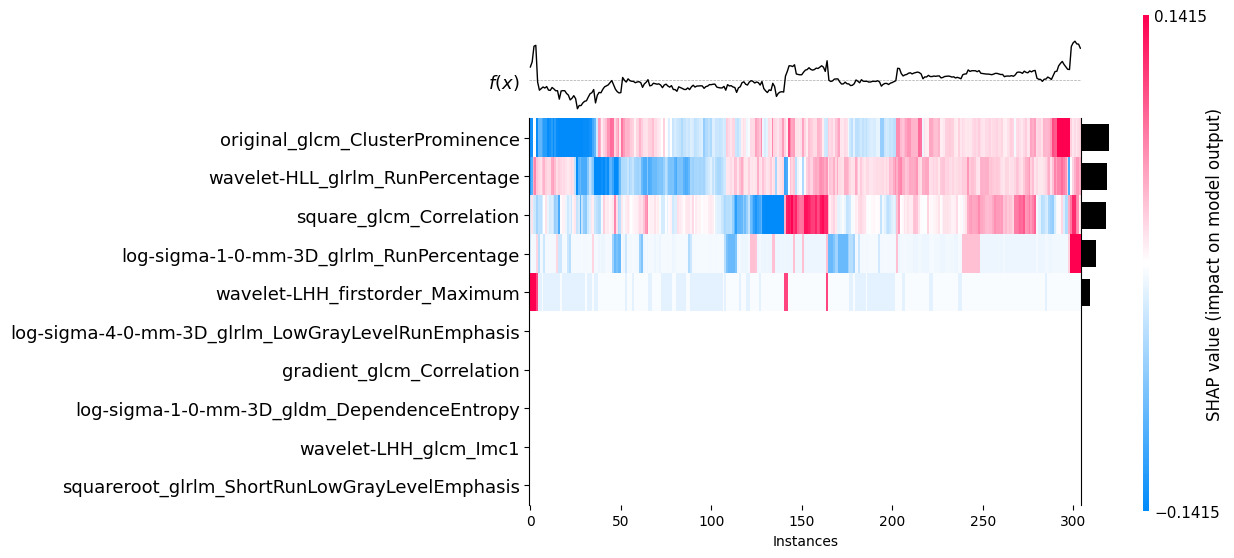

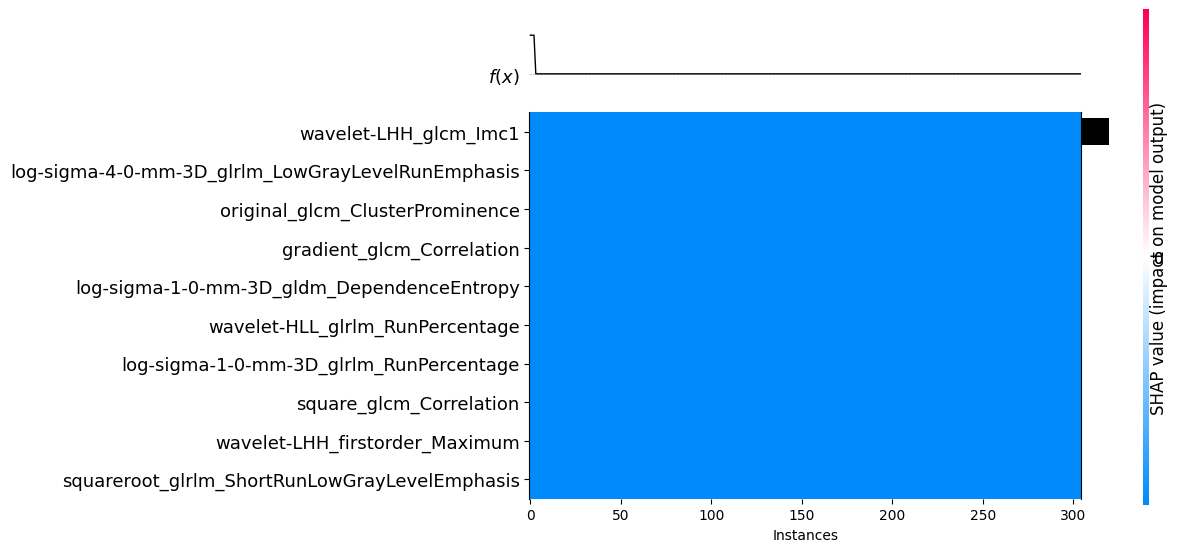

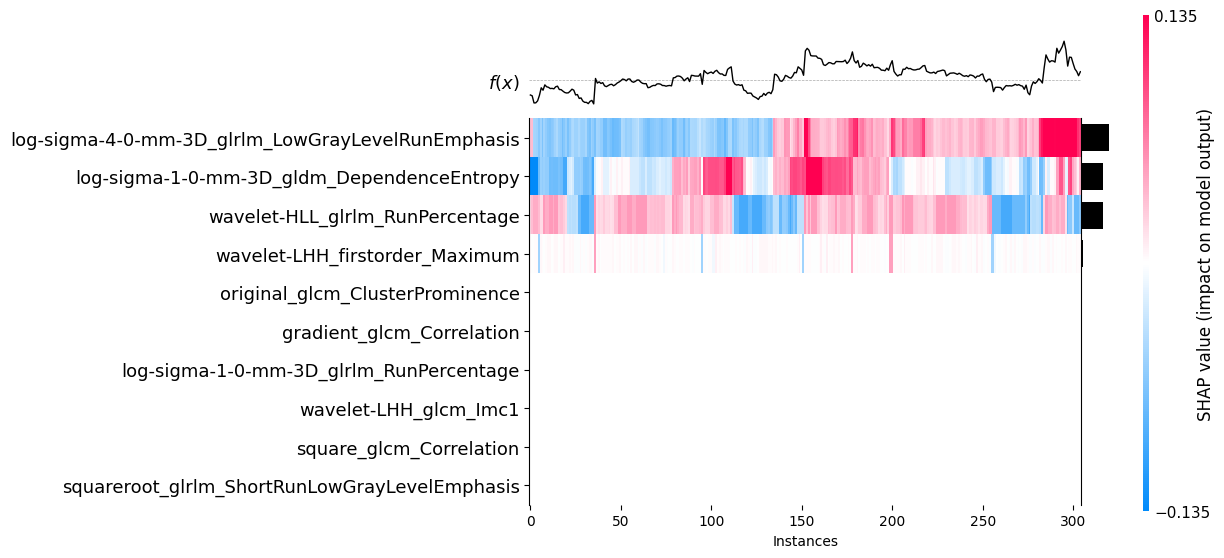

KeyboardInterrupt: 

In [91]:
show_shap_importance_heatmap(shap_values,X_shap)

In [ ]:
show_shap_importance_summary_plot(shap_values,X_shap)

### Local

# Checkpoint?

In [ ]:
shap_train_df.to_csv("../Dataset/train_test.csv",index=False)

# Models Tester

In [159]:
results = {}
x_train, x_test, y_train, y_test = define_X_y(shap_train_df,random_state=27)
main_exploration(x_train)
main_exploration(x_test)

(244, 185)
(61, 185)


## Basic Models

F1 Macro Score em RandomForest: 0.33836700642453776 ± 0.048
F1 Macro Score em XGBoost: 0.3928930582808897 ± 0.056
F1 Macro Score em LightGBM: 0.4126544796398396 ± 0.04
F1 Macro Score em SVM: 0.3406171867359042 ± 0.04


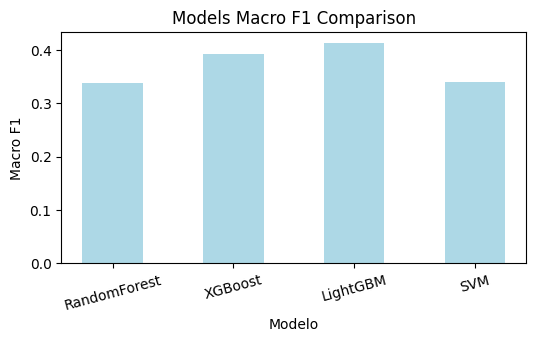

In [160]:
rf_model, xgb_model, gradient_model, cat_model, log_model, light_model,svm_model = apply_basic_models(x_train,y_train,x_test,y_test,n_repeats=3)

F1 Macro Score em RandomForest: 0.33836700642453776
F1 Macro Score em XGBoost: 0.3928930582808897
F1 Macro Score em LightGBM: 0.4126544796398396
F1 Macro Score em SVM: 0.3406171867359042
F1 Macro Score em StackingBasic: 0.39849429171879347 ± 0.06
F1 Macro Score em StackingBasicSVM: 0.38034960090379777 ± 0.056


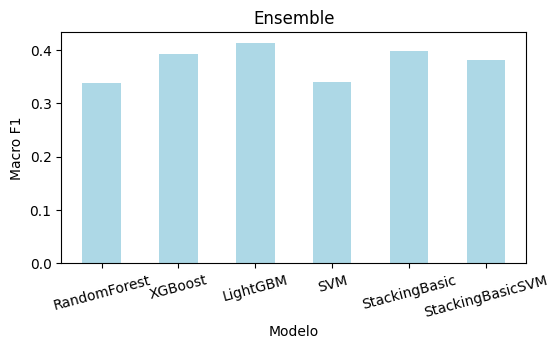

In [163]:
stacking_model = stacking_ensemble(x_train,y_train,[("rf",rf_model),("xgb",xgb_model),("light",light_model)])
results["StackingBasic"] = [stacking_model,None]
stacking_model_svm = stacking_ensemble(x_train,y_train,[("svm",svm_model),("rf",rf_model),("xgb",xgb_model),("light",light_model)])
results["StackingBasicSVM"] = [stacking_model_svm,None]

models_comparison(results,"Ensemble",x_train=x_train,y_train=y_train,n_repeats=4)

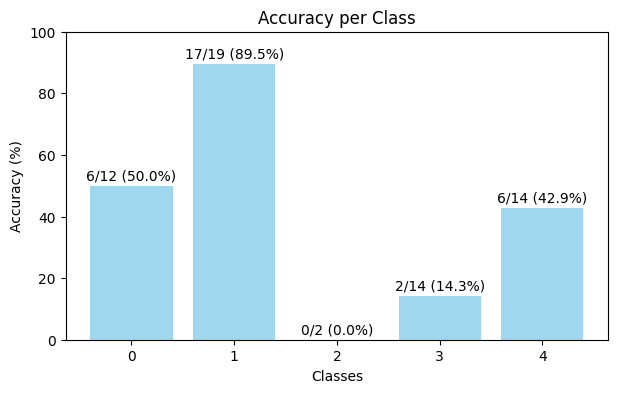

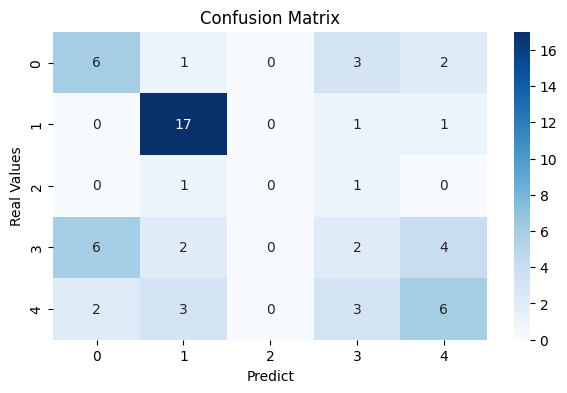

In [162]:
class_accuracy(stacking_model,x_test,y_test)

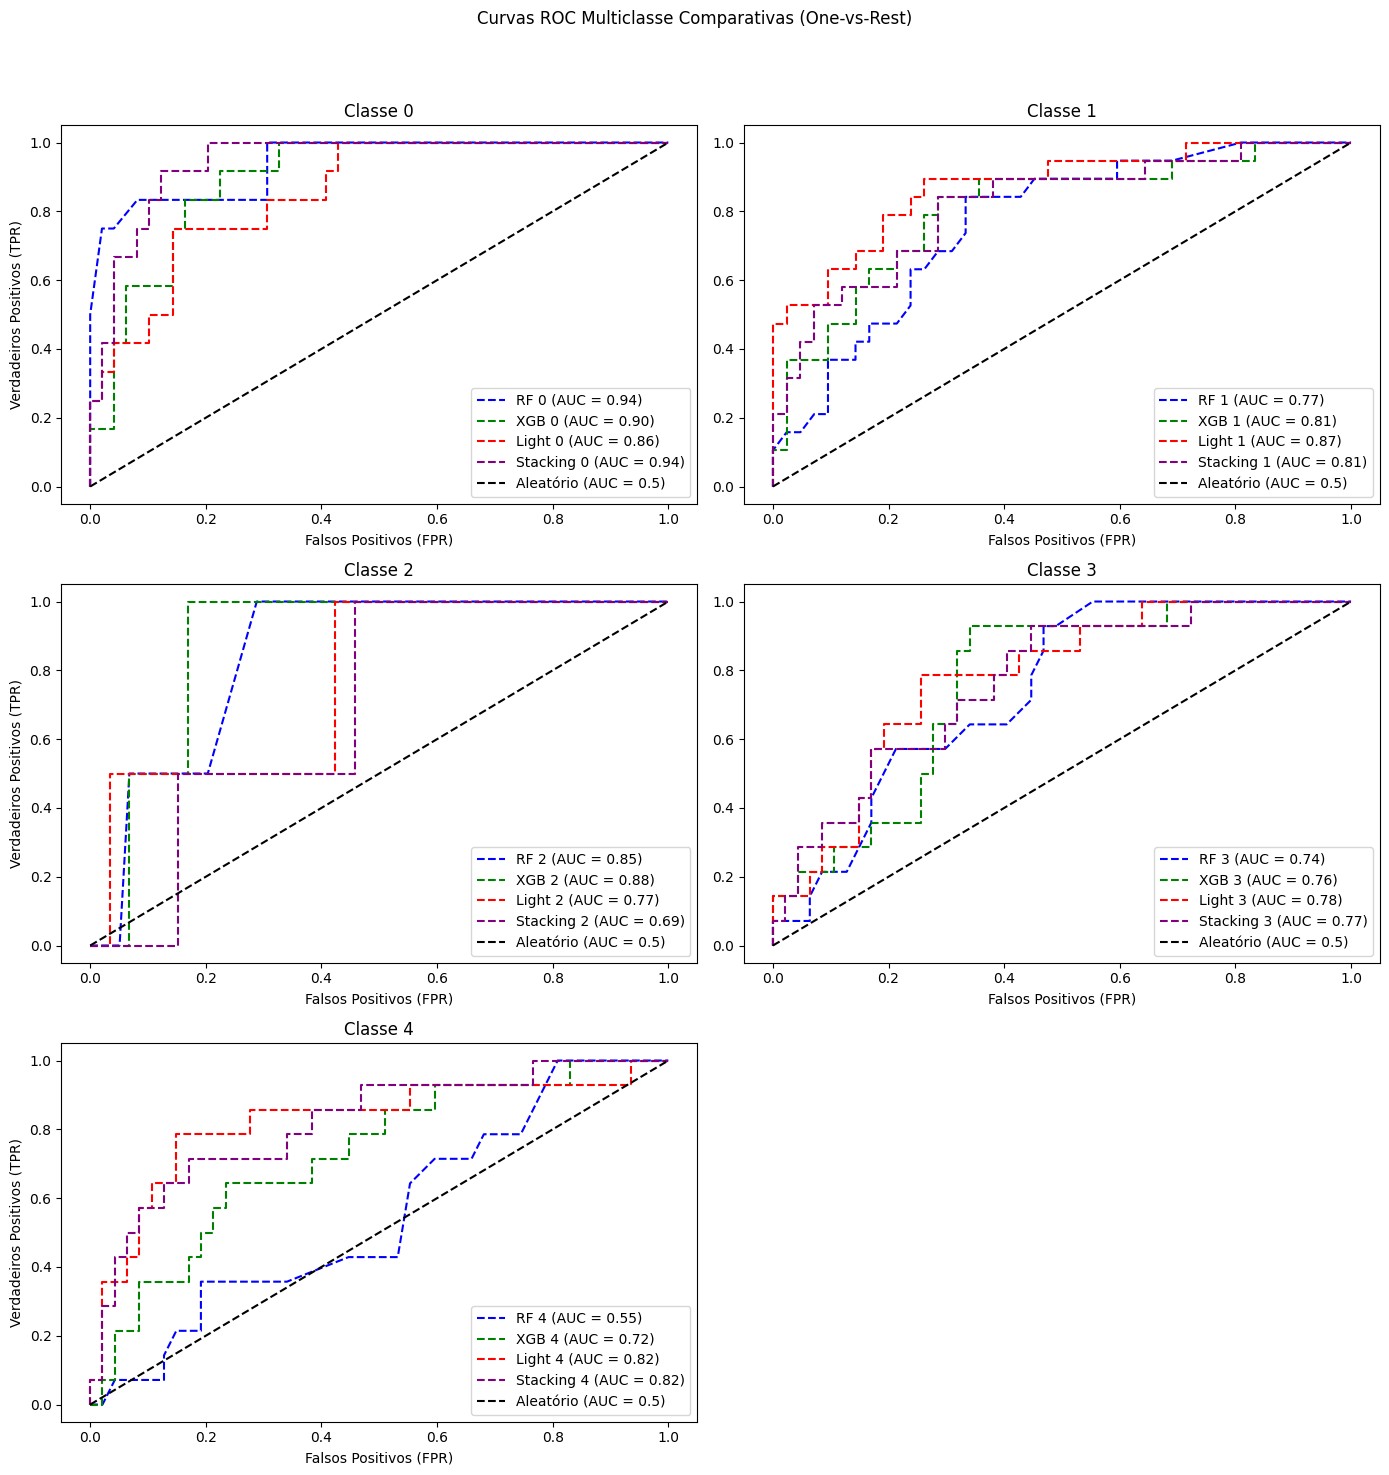

In [111]:
models = {"RF": rf_model,"XGB": xgb_model,"Light":light_model,"Stacking": stacking_model}
roc_auc(models,x_train, y_train, x_test, y_test)

## BayesOptimizer Tuning

In [ ]:
def bayes_visualization(params,bayes_results,best_hyperparameters):
    param_names = list(params.keys())

    cols = 3
    rows = math.ceil(len(param_names)/cols)
    
    fig, axes = plt.subplots(rows,cols,figsize=(4*cols,4*rows))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, param in enumerate(param_names):
        if param != "target":
            ax = axes[i//3, i%3]
            ax.plot(bayes_results['params'].apply(lambda x: x[param]),
                bayes_results['target'], 'bo-', lw=1, markersize=4)
            ax.set_title(f'Optimization of {param}')
            ax.set_xlabel(param)
            ax.set_ylabel('F1 Macro Score')
     
            best_value = best_hyperparameters['params'][param]
            ax.plot(best_value, best_hyperparameters['target'], 'yo', markersize=6)
            
    for i in range(len(param_names), 6):
        fig.delaxes(axes.flatten()[i])
 
    plt.show()

In [ ]:
results = {}

rf_baye_model, rf_baye_results, best_params = random_forest_baye_model(x_train,y_train)
results["RandomForestBaye"] = [rf_baye_model,None]
bayes_visualization(param_baye_rf, rf_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

xgb_baye_model, xgb_baye_results, best_params = xgboost_baye_model(x_train,y_train)
results["XGBoostBaye"] = [xgb_baye_model,None]
bayes_visualization(param_baye_xgb, xgb_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

light_baye_model, light_baye_results, best_params = light_baye_train_model(x_train,y_train)
results["LightBoostBaye"] = [light_baye_model,None]
bayes_visualization(param_baye_light, light_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

svm_baye_model, svm_baye_results, best_params = svm_baye_train_model(x_train,y_train)
results["SVMBaye"] = [svm_baye_model,None]
bayes_visualization(param_baye_svm, svm_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

In [ ]:
rf_ensemble = RandomForestClassifier(**rf_baye_model.get_params())

In [ ]:
xgb_ensemble = XGBClassifier(**xgb_baye_model.get_params())

In [ ]:
light_ensemble = lgb.LGBMClassifier(**light_baye_model.get_params())

In [ ]:
svm_ensemble = SVC(**svm_baye_model.get_params())

In [ ]:
stacking_model = stacking_ensemble(x_train,y_train,[("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])
results["StackingBaye"] = [stacking_model,None]
stacking_model_svm = stacking_ensemble(x_train,y_train,[("svm",svm_ensemble),("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])
results["StackingBayeSVM"] = [stacking_model_svm,None]

models_comparison(results,"Ensemble",x_train=x_train,y_train=y_train,n_repeats=10)

In [ ]:
class_accuracy(stacking_model_svm,x_test,y_test)

## GridSearch Tuning

In [ ]:
results = {}
rf_grid_model = random_forest_grid_model(x_train,y_train)
results["RandomForestGrid"] = [rf_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

xgb_grid_model = xgboost_grid_model(x_train,y_train)
results["XGBoostGrid"] = [xgb_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

light_grid_model = light_grid_train_model(x_train,y_train)
results["lightGrid"] = [light_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

svm_grid_model = svm_grid_train_model(x_train,y_train)
results["SVMGrid"] = [svm_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

In [ ]:
rf_ensemble = RandomForestClassifier(**rf_grid_model.get_params())
xgb_ensemble = XGBClassifier(**xgb_grid_model.get_params())
light_ensemble = lgb.LGBMClassifier(**light_grid_model.get_params())
svm_ensemble = SVC(**svm_grid_model.get_params())

stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])
#stacking_model_svm = stacking_ensemble(x_train,y_train,estimators=[("svm",svm_ensemble),("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])

results["StackingGrid"] = [stacking_model,None]
#results["StackingGridSVM"] = [stacking_model_svm,None]

models_comparison(results,"Grid Ensemble",x_train=x_train,y_train=y_train,n_repeats=10)

In [ ]:
class_accuracy(stacking_model,x_test,y_test)

## Ensemble with Best Models

In [ ]:
rf_best_model = RandomForestClassifier(**rf_baye_model.get_params())
xgb_best_model = XGBClassifier(**xgb_grid_model.get_params())
light_best_model = lgb.LGBMClassifier(**light_grid_model.get_params())
svm_best_model = SVC(**svm_grid_model.get_params())

stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_best_model),("xgb",xgb_best_model),("light",light_best_model)])
stacking_model_svm = stacking_ensemble(x_train,y_train,estimators=[("svm",svm_best_model),("rf",rf_best_model),("xgb",xgb_best_model),("light",light_best_model)])

results["StackingGrid"] = [stacking_model,None]
results["StackingGridSVM"] = [stacking_model_svm,None]

models_comparison(results,"Grid Ensemble",x_train=x_train,y_train=y_train,n_repeats=10)

In [ ]:
class_accuracy(stacking_model,x_test,y_test)

# Get Preds

In [ ]:
results = {}
x_train_final, x_test_final, y_train_final, y_test_final = define_X_y(shap_train_df,shap_test_df,random_state=60)
main_exploration(x_train_final)
main_exploration(x_test_final)

In [ ]:
rf_params = rf_model.get_params()
xgb_params = xgb_model.get_params()
light_params = light_model.get_params()
svm_params = svm_model.get_params()

In [ ]:
rf_baye_params = rf_baye_model.get_params()
xgb_baye_params = xgb_baye_model.get_params()
light_baye_params = light_baye_model.get_params()
svm_baye_params = svm_baye_model.get_params()

In [ ]:
rf_grid_params = rf_grid_model.get_params()
xgb_grid_params = xgb_grid_model.get_params()
light_grid_params = light_grid_model.get_params()
svm_grid_params = svm_grid_model.get_params()

In [ ]:
rf_preds_model = RandomForestClassifier(**rf_params)
xgb_preds_model = XGBClassifier(**xgb_params)
light_preds_model = lgb.LGBMClassifier(**light_params)
svm_preds_model = SVC(**svm_params)

In [ ]:
stacking_model = stacking_ensemble(x_train_final,y_train_final,estimators=[("rf",rf_preds_model),("xgb",xgb_preds_model),("light",light_preds_model)])
stacking_model_svm = stacking_ensemble(x_train_final,y_train_final,estimators=[("svm",svm_preds_model),("rf",rf_preds_model),("xgb",xgb_preds_model),("light",light_preds_model)])


## Final Test

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import numpy as np

def final_test_cv(model, x_train, y_train, n_repeats=5, n_splits=5,random_state=27):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    score_mean = cross_val_score(model, x_train, y_train, cv=cv, scoring='f1_macro').mean()
    
    print(f"F1 Score mean Stacking: {score_mean}")


In [ ]:
final_test_cv(stacking_model,x_train_final,y_train_final,n_repeats=10,n_splits=5,random_state=32)
final_test_cv(stacking_model,x_train_final,y_train_final,n_repeats=10,n_splits=5,random_state=431432)
final_test_cv(stacking_model,x_train_final,y_train_final,n_repeats=10,n_splits=5,random_state=323232)
final_test_cv(stacking_model,x_train_final,y_train_final,n_repeats=10,n_splits=5,random_state=6565652)
final_test_cv(stacking_model,x_train_final,y_train_final,n_repeats=5,n_splits=10,random_state=22)

## Preds to CSV

In [ ]:
def preds_to_csv(preds, df=dummy_df):
    if len(preds) == 100:
        y_pred_original = target_decoder(le_make_train, preds)
        
        df["Result"] = y_pred_original
        
        df.to_csv("../Dataset/dummy_submission.csv", index=False)

        print("CSV updated!\n", y_pred_original)
    else:
        print("Invalid input!")


In [ ]:
preds_to_csv(stacking_model.predict(x_test_final))

In [ ]:
save_stuff(stacking_model,"Models/New_Models/new_era_stacking.pkl")
save_stuff(stacking_model_svm,"Models/New_Models/new_era_stackingsvm.pkl")

In [ ]:
stacking_model